In [1]:
%pip install torch torchvision torchaudio opacus


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Very first thing is to clean our data. Let's make a csv file with only the relevant columns:
import pandas as pd
import numpy as np


# Edit the next line to pick what we are researching
research = 'loan'

file_path = f'data/{research}_data.csv'  
    
# Rename FIRST
df = pd.read_csv(file_path, dtype=str, low_memory=False)
df.rename(columns={'derived_race': 'race', 'derived_sex': 'sex'}, inplace=True)
df['race'] = df['race'].replace({'Black or African American': 'Black'})

col = "sex"
unique_count = df[col].nunique()
    

print(f"Unique values: {unique_count}") 
print(df[col].value_counts())
print(len(df))
# Use the renamed column names
selected_columns = [
    'derived_dwelling_category', 'conforming_loan_limit', 'race', 'sex', 'action_taken', 'loan_type', 'loan_purpose',
    'lien_status', 'reverse_mortgage', 'open-end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio', 'hoepa_status', 'loan_term', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features',
    'property_value', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest',
    'income', 'debt_to_income_ratio', 'applicant_credit_score_type', 'applicant_race_observed', 'applicant_sex_observed', 'applicant_age', 
    'tract_population', 'tract_minority_population_percent', 'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage'
]
df = df[selected_columns]

# Now use renamed 'race' safely
categorical_features = ['derived_dwelling_category', 'conforming_loan_limit', 'race', 'sex', 'loan_type', 'loan_purpose', 'lien_status',
                        'reverse_mortgage', 'open-end_line_of_credit', 'business_or_commercial_purpose', 'hoepa_status', 'negative_amortization', 'interest_only_payment',
                        'balloon_payment', 'other_nonamortizing_features', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest',
                        'debt_to_income_ratio', 'applicant_credit_score_type', 'applicant_race_observed', 'applicant_sex_observed', 'applicant_age']

numeric_features = [col for col in df.columns if col not in categorical_features + ['action_taken']]
# Drop rows with invalid categorical values
invalid_vals = ['', 'nan', 'NaN', 'NA', 'Exempt']
df.replace(invalid_vals, np.nan, inplace=True)
df = df[~df[categorical_features].astype(str).isin(invalid_vals).any(axis=1)]

# Create target
df['target'] = df['action_taken'].map({'1': 1, '3': 0})
df = df.dropna()

# Finalize

    

print(len(df.columns))

    

Unique values: 4
sex
Joint                158558
Male                 146240
Female                99213
Sex Not Available      2740
Name: count, dtype: int64
406751
34


In [3]:
# We want to divide our data into training, evaluation, and testing sets
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X = df.drop(columns=['target', 'action_taken'])
y = df['target']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])


X_train_eval, X_test, y_train_eval, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train_eval, y_train_eval, stratify=y_train_eval, test_size=0.125, random_state=42)

# Fit only on training
print(f"Training set size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Evaluation set size: {len(X_eval)} ({len(X_eval)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")


# Scale all data fit to training data only.
X_train_scaled = preprocessor.fit_transform(X_train)
X_eval_scaled = preprocessor.transform(X_eval)
X_test_scaled = preprocessor.transform(X_test)
X_scaled= preprocessor.transform(X)


feature_names = [name.split('__')[1] for name in preprocessor.get_feature_names_out()]
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names, index=X.index)
df_with_target = X_scaled_df.copy()

df_with_target['target'] = y



Training set size: 258328 (70.0%)
Evaluation set size: 36905 (10.0%)
Test set size: 73809 (20.0%)


In [4]:
# Train a simple logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = logreg.predict(X_eval_scaled)
y_prob = logreg.predict_proba(X_eval_scaled)[:, 1]

accuracy = accuracy_score(y_eval, y_pred)
auc = roc_auc_score(y_eval, y_prob)
report = classification_report(y_eval, y_pred, output_dict=True)

print(f"Accuracy: {accuracy:.6f}, \nAUC: {auc:.6f}, \nPrecision: {report['1']['precision']:.6f},\nRecall: {report['1']['recall']:.6f}, \nF1: {report['1']['f1-score']:.6f}")


Accuracy: 0.973852, 
AUC: 0.996313, 
Precision: 0.987354,
Recall: 0.978086, 
F1: 0.982698


In [5]:
# Mostly for testing, we want to make sure we are not including variables that only can take on certain values because of the dependent variable.
# Only can use features that come about before the outcome is decided.
# Get feature names

# Get coefficients
coefs = logreg.coef_[0]  # shape: (n_features,)

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'abs_coef': np.abs(coefs)
})

# Sort by magnitude of coefficient
importance_df = importance_df.sort_values(by='abs_coef', ascending=False)

print(importance_df.head(50))  # Top 20 most influential features

                                               feature  coefficient  abs_coef
42                                      hoepa_status_3    -7.479743  7.479743
41                                      hoepa_status_2     6.142055  6.142055
84                           debt_to_income_ratio_>60%    -4.016116  4.016116
55                                    occupancy_type_1    -2.205969  2.205969
52                      other_nonamortizing_features_1     1.836770  1.836770
54                      other_nonamortizing_features_2    -1.738027  1.738027
82                        debt_to_income_ratio_50%-60%    -1.552220  1.552220
56                                    occupancy_type_2     1.452013  1.452013
40                                      hoepa_status_1     1.436435  1.436435
43                             negative_amortization_1     1.296269  1.296269
45                             negative_amortization_2    -1.197526  1.197526
25                                      loan_purpose_1     1.185

In [6]:
# Now we train a CNN instead, just to compare results
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
# Prepare the data
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)  # Add channel dim
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_eval_tensor = torch.tensor(X_eval_scaled, dtype=torch.float32).unsqueeze(1)
y_eval_tensor = torch.tensor(y_eval.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

total_dataset = TensorDataset(X_tensor, y_tensor)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
eval_dataset = TensorDataset(X_eval_tensor, y_eval_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

total_loader = DataLoader(total_dataset, batch_size=2048)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=2048)
test_loader = DataLoader(test_dataset, batch_size=2048)

class TabularMLP(nn.Module):
    def __init__(self, input_len):
        super(TabularMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_len, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(1)  
        return self.model(x)

# Instantiate model
def instantiate_model():
    model = TabularMLP(input_len=X_train_scaled.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    return model, criterion, optimizer

model, criterion, optimizer = instantiate_model()

In [8]:
def evaluate(verbose=False):
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_eval_tensor).numpy()
        y_pred_label = (y_pred_prob > 0.5).astype(int)
    y_true = y_eval_tensor.numpy().astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    if(verbose):
        auc = roc_auc_score(y_true, y_pred_prob)
        report = classification_report(y_true, y_pred_label, output_dict=True)
        print(f"Accuracy: {accuracy}, \nAUC: {auc}, \nPrecision: {report['1']['precision']},\nRecall: {report['1']['recall']}, \nF1: {report['1']['f1-score']}")
    return accuracy

#Same thing, just on the test set
def test(verbose=False):
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_test_tensor).numpy()
        y_pred_label = (y_pred_prob > 0.5).astype(int)
    y_true = y_test_tensor.numpy().astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    if(verbose):
        auc = roc_auc_score(y_true, y_pred_prob)
        report = classification_report(y_true, y_pred_label, output_dict=True)
        print(f"Accuracy: {accuracy}, \nAUC: {auc}, \nPrecision: {report['1']['precision']},\nRecall: {report['1']['recall']}, \nF1: {report['1']['f1-score']}")
    return accuracy

In [22]:
# Training loop
from pathlib import Path
train = False
def training_loop(train=True, path=None):
    model, criterion, optimizer = instantiate_model()
    if(path):
        model_save_filepath = path
    else:
        model_save_filepath = f'mlp_models_unscaled/baselineCNN_{research}'
    if(train):
        
        max_eval_accuracy = 0
        max_epochs = 1000
        max_epochs_without_improvement = 50
        current_epochs_without_improvement = 0
        if Path(model_save_filepath).exists():
            model.load_state_dict(torch.load(model_save_filepath, weights_only=True))
            max_eval_accuracy = evaluate()
        for epoch in range(max_epochs):
            model.train()
            epoch_loss = 0.0
            for inputs, labels in train_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")
            # Evaluate
            model.eval()
            with torch.no_grad():
                predictions = model(X_eval_tensor)
                predicted_classes = (predictions > 0.5).float()
            accuracy = (predicted_classes == y_eval_tensor).float().mean().item()
            print(f"Evaluation Accuracy: {accuracy:.4f}")
            if(accuracy > max_eval_accuracy):
                torch.save(model.state_dict(), model_save_filepath)
                current_epochs_without_improvement = 0
                max_eval_accuracy = accuracy
                print("Saved model")
            else:
                current_epochs_without_improvement += 1
                if current_epochs_without_improvement > max_epochs_without_improvement:
                    break
    else:
        if Path(model_save_filepath).exists():
            model.load_state_dict(torch.load(model_save_filepath, weights_only=True))
            max_eval_accuracy = evaluate(verbose=True)
if(train):
    training_loop()

In [10]:
# Evaluate
model_save_filepath = f'mlp_models_unscaled/baselineCNN_{research}'
model.load_state_dict(torch.load(model_save_filepath, weights_only=True))
evaluate(verbose=True)
test(verbose=True)


Accuracy: 0.9768324075328546, 
AUC: 0.9970354711796199, 
Precision: 0.9889832949308756,
Recall: 0.9804061529676291, 
F1: 0.9846760462407026
Accuracy: 0.9759514422360417, 
AUC: 0.9967877933419891, 
Precision: 0.9886177397568663,
Recall: 0.979602398458134, 
F1: 0.9840894219306029


0.9759514422360417

In [11]:
# Now we experiment
# This can mostly be done for the final project step, but let's do a similar analysis to HW1, seeing the bias in the data itself.
from matplotlib import pyplot as plt


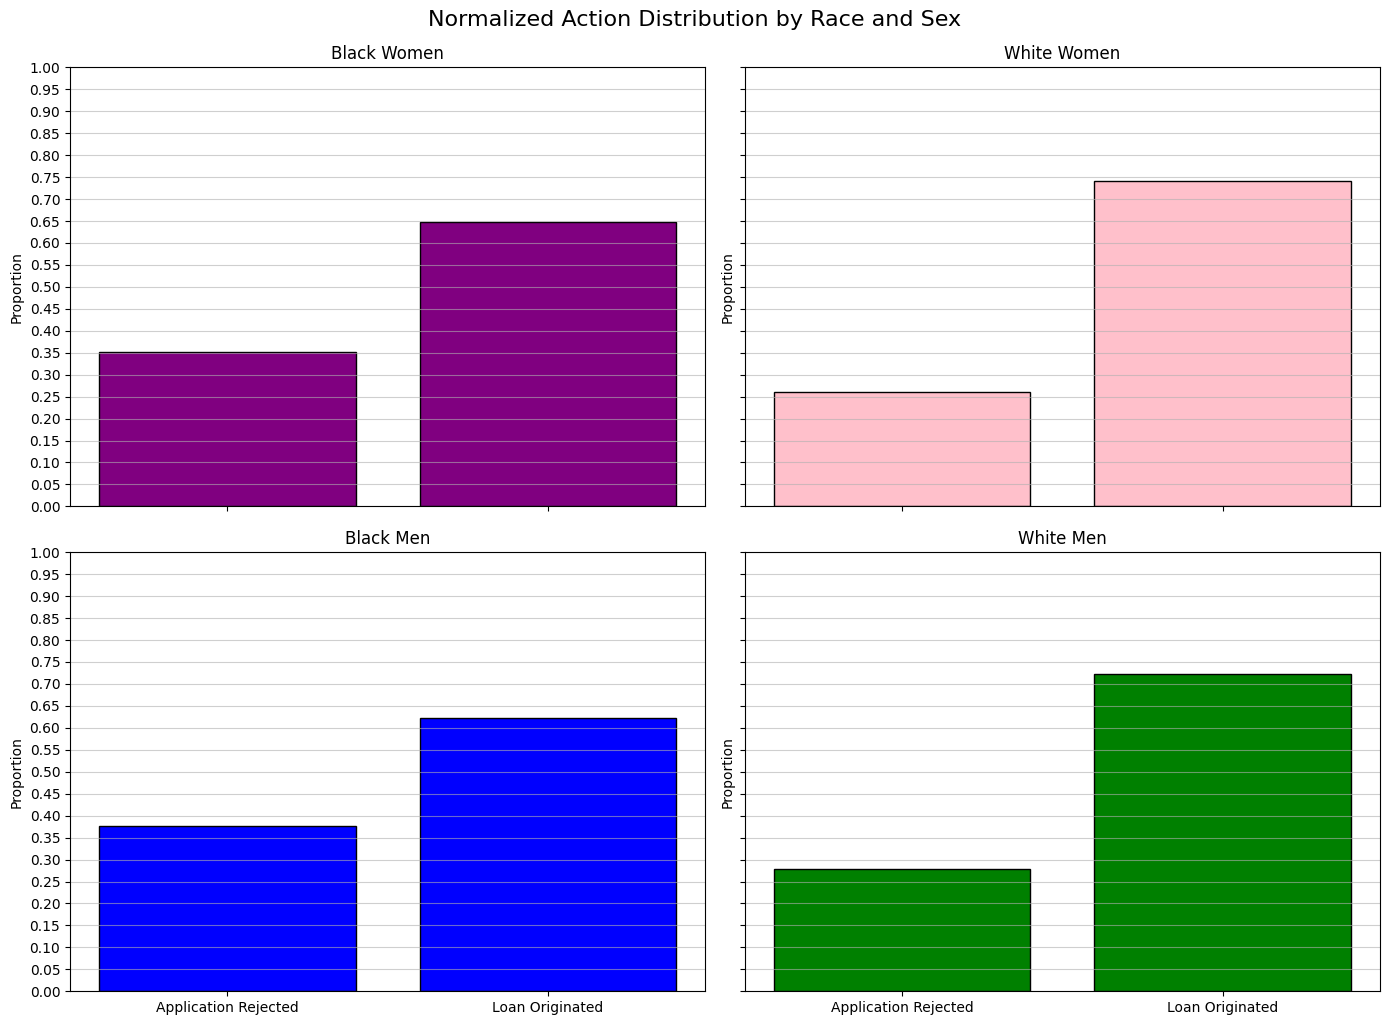

In [12]:
import matplotlib.pyplot as plt
import numpy as np

if research == 'income':
    # Mapping for label readability
    income_label_map = {0: '<=50K', 1: '>50K'}

    # Overall distribution
    plt.figure(figsize=(10, 6))
    income_counts = df_with_target['target'].value_counts(normalize=True).sort_index()
    income_labels = [income_label_map[i] for i in income_counts.index]
    plt.bar(income_labels, income_counts, color='skyblue', edgecolor='black')
    plt.title('Distribution of Income')
    plt.xlabel('Income')
    plt.ylabel('Proportion of Individuals')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Subgroups
    black_women = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Female'] == 1)]
    white_women = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Female'] == 1)]
    black_men = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Male'] == 1)]
    white_men = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Male'] == 1)]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

    def plot_normalized_hist(ax, data, title, color):
        counts = data['target'].value_counts(normalize=True).sort_index()
        labels = [income_label_map.get(i, str(i)) for i in counts.index]
        ax.bar(labels, counts, color=color, edgecolor='black')
        ax.set_title(title)
        ax.set_ylim(0, 1)

    plot_normalized_hist(axes[0, 0], black_women, 'Black Women', 'purple')
    plot_normalized_hist(axes[0, 1], white_women, 'White Women', 'pink')
    plot_normalized_hist(axes[1, 0], black_men, 'Black Men', 'blue')
    plot_normalized_hist(axes[1, 1], white_men, 'White Men', 'green')

    for ax in axes.flat:
        ax.set_ylabel('Proportion')
        ax.grid(axis='y', alpha=0.6)

    plt.tight_layout()
    plt.suptitle('Normalized Income Distribution by Race and Sex', fontsize=16, y=1.02)
    plt.show()

elif research == 'loan':
    action_label_map = {1: 'Loan Originated', 0: 'Application Rejected'}

    # Demographic subsets
    black_women = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Female'] == 1)]
    white_women = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Female'] == 1)]
    black_men = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Male'] == 1)]
    white_men = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Male'] == 1)]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

    def plot_normalized_hist(ax, data, title, color):
        counts = data['target'].value_counts(normalize=True).sort_index()
        labels = [action_label_map.get(i, str(i)) for i in counts.index]
        ax.bar(labels, counts, color=color, edgecolor='black')
        ax.set_title(title)
        ax.set_ylim(0, 1)

    plot_normalized_hist(axes[0, 0], black_women, 'Black Women', 'purple')
    plot_normalized_hist(axes[0, 1], white_women, 'White Women', 'pink')
    plot_normalized_hist(axes[1, 0], black_men, 'Black Men', 'blue')
    plot_normalized_hist(axes[1, 1], white_men, 'White Men', 'green')

    for ax in axes.flat:
        ax.set_ylabel('Proportion')
        ax.grid(axis='y', alpha=0.6)
        ax.set_yticks(np.arange(0, 1.05, 0.05))

    plt.tight_layout()
    plt.suptitle('Normalized Action Distribution by Race and Sex', fontsize=16, y=1.02)
    plt.show()


moo


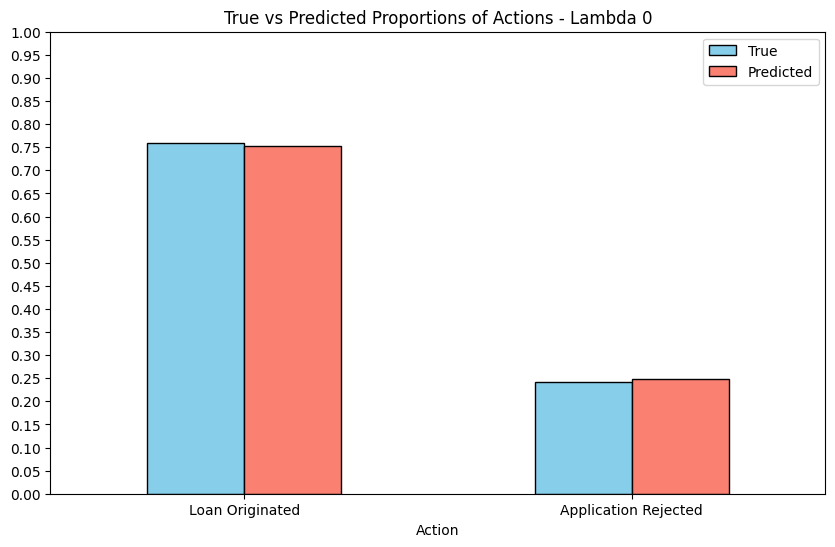

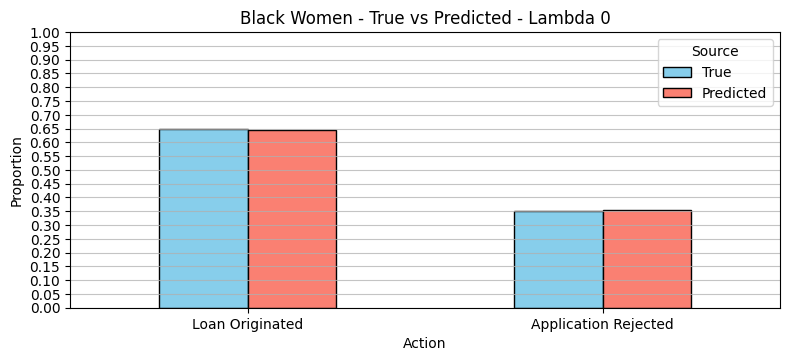

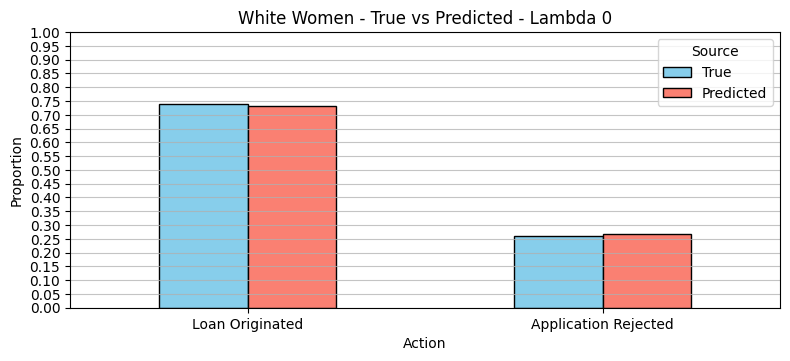

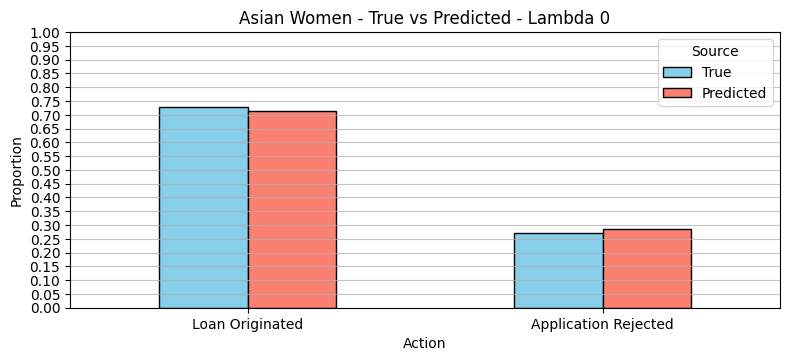

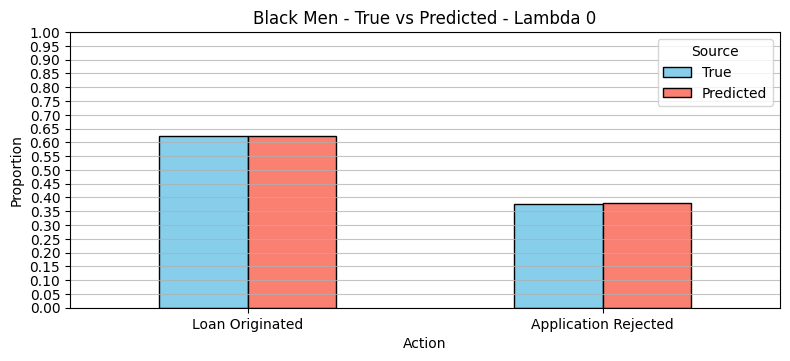

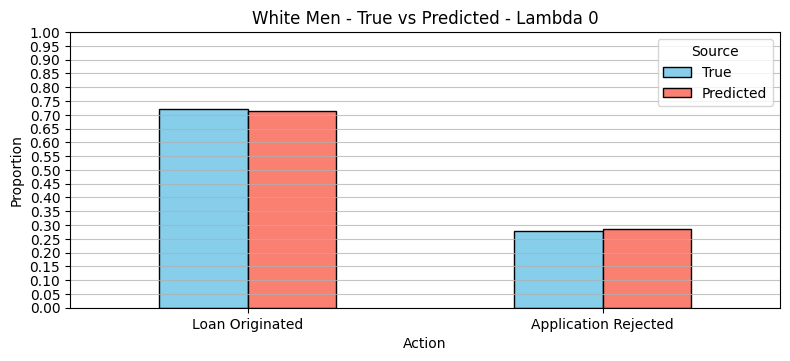

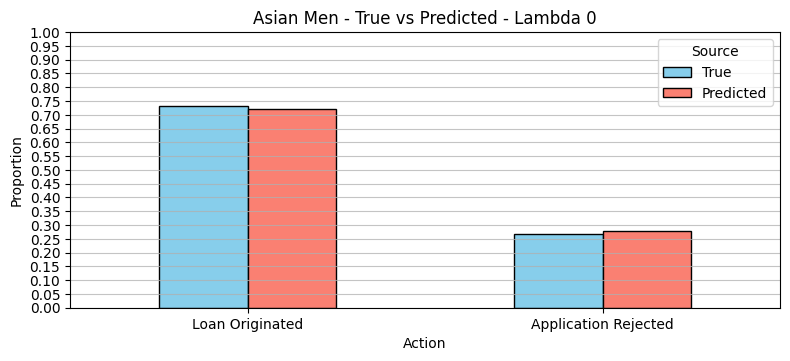

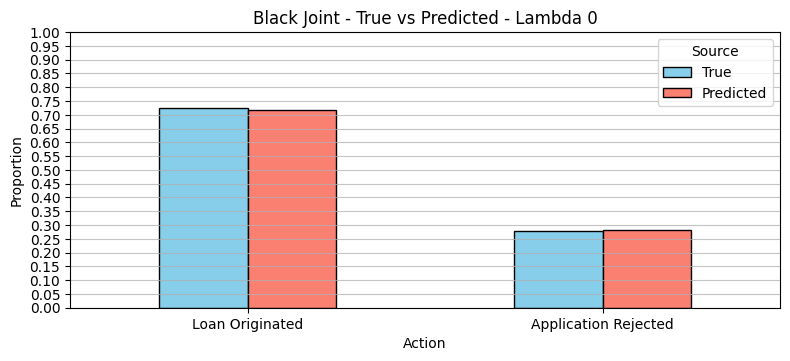

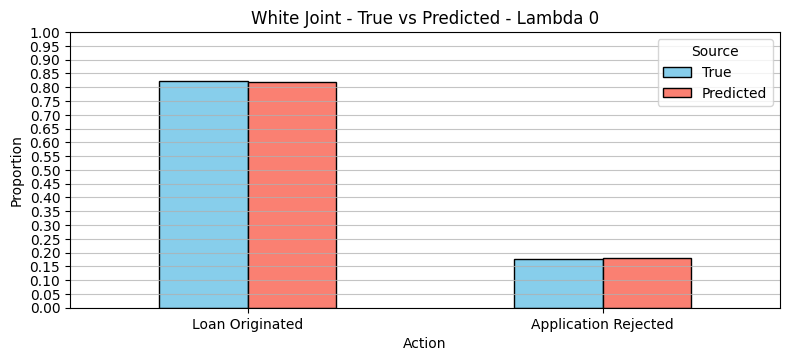

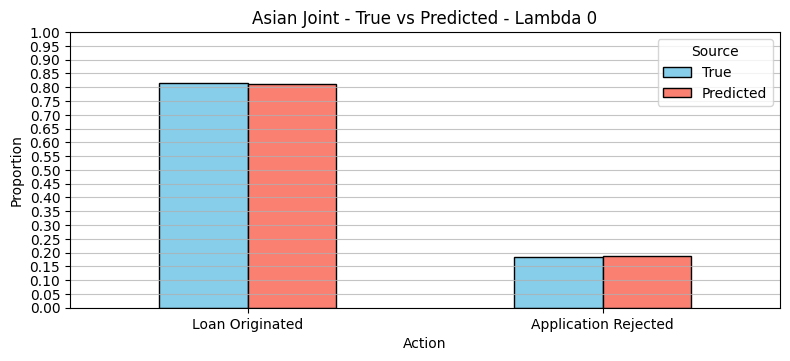

0

In [13]:
def evaluate_independence(path, custom_title = 0, plot=True, data=False):
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_tensor).numpy()
        y_pred_label = (y_pred_prob > 0.5).astype(int)
    # Flatten predicted labels
    y_pred_label_flat = y_pred_label.ravel()
    if research == 'income':
        label_map = {1: '<=50K', 0: '>50K'}
    elif research == 'loan':
        label_map = {1: 'Loan Originated', 0: 'Application Rejected'}  # adjust if needed
    true_labels = df_with_target['target'].map(label_map)
    pred_labels = pd.Series(y_pred_label_flat).map(label_map)

    # Value counts (normalized)
    true_counts = true_labels.value_counts(normalize=True)
    pred_counts = pred_labels.value_counts(normalize=True)
    # Combine into a DataFrame
    df_plot = pd.DataFrame({
        'True': true_counts,
        'Predicted': pred_counts
    }).fillna(0)  # Fill missing values if a class isn't predicted
    # Plot
    if(plot):
        print("moo")
        df_plot.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'], edgecolor='black')
        plt.yticks(np.arange(0, 1.05, 0.05))
        plt.xticks(rotation=0)
    black_women = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Female'] == 1)]
    white_women = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Female'] == 1)]
    asian_women = df_with_target[(df_with_target['race_Asian'] == 1) & (df_with_target['sex_Female'] == 1)]
    black_men = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Male'] == 1)]
    white_men = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Male'] == 1)]
    asian_men = df_with_target[(df_with_target['race_Asian'] == 1) & (df_with_target['sex_Male'] == 1)]
    black_joint = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Joint'] == 1)]
    white_joint = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Joint'] == 1)]
    asian_joint = df_with_target[(df_with_target['race_Asian'] == 1) & (df_with_target['sex_Joint'] == 1)]

    X_bw_scaled = black_women.drop(columns=['target'])
    X_ww_scaled = white_women.drop(columns=['target'])
    X_aw_scaled = asian_women.drop(columns=['target'])
    X_bm_scaled = black_men.drop(columns=['target'])
    X_wm_scaled = white_men.drop(columns=['target'])
    X_am_scaled = asian_men.drop(columns=['target'])
    X_bj_scaled = black_joint.drop(columns=['target'])  
    X_wj_scaled = white_joint.drop(columns=['target'])
    X_aj_scaled = asian_joint.drop(columns=['target'])

    X_bw_tensor = torch.tensor(X_bw_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_ww_tensor = torch.tensor(X_ww_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_am_tensor = torch.tensor(X_am_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_bm_tensor = torch.tensor(X_bm_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_wm_tensor = torch.tensor(X_wm_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_aw_tensor = torch.tensor(X_aw_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_bj_tensor = torch.tensor(X_bj_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_wj_tensor = torch.tensor(X_wj_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_aj_tensor = torch.tensor(X_aj_scaled.values, dtype=torch.float32).unsqueeze(1)

    
    groups = {
        "Black Women": (black_women, X_bw_tensor),
        "White Women": (white_women, X_ww_tensor),
        "Asian Women": (asian_women, X_aw_tensor),
        "Black Men": (black_men, X_bm_tensor),
        "White Men": (white_men, X_wm_tensor),
        "Asian Men": (asian_men, X_am_tensor),
        "Black Joint": (black_joint, X_bj_tensor),
        "White Joint": (white_joint, X_wj_tensor),
        "Asian Joint": (asian_joint, X_aj_tensor),
    }
    if(plot):
        if research == 'income':
            plt.title('True vs Predicted Proportions of Actions')
            plt.xlabel('Action')

        elif research == 'loan':
            plt.title(f'True vs Predicted Proportions of Actions - Lambda {custom_title}')
            plt.xlabel('Action')
    
    group_ratios = []
    total_approval = 0
    total_count = 0
    for group_name, (group_df, group_X_tensor) in groups.items():
        with torch.no_grad():
            y_pred_prob = model(group_X_tensor).numpy()
            y_pred_label = (y_pred_prob > 0.5).astype(int).ravel()
            group_ratios.append(y_pred_label.mean())
        # Map labels to strings
        true_labels = group_df['target'].map(label_map)
        pred_labels = pd.Series(y_pred_label).map(label_map)
        
        total_approval += group_df['target'].sum()
        total_count += len(group_df)
        # Value counts (normalized)
        true_counts = true_labels.value_counts(normalize=True)
        pred_counts = pred_labels.value_counts(normalize=True)
        # Combine into DataFrame
        df_plot = pd.DataFrame({
            'True': true_counts,
            'Predicted': pred_counts
        }).fillna(0)

        # Plot
        if(plot):
            ax = df_plot.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'], edgecolor='black')
            plt.title(f'{group_name} - True vs Predicted - Lambda {custom_title}')
            plt.ylabel('Proportion')
            if research == 'income':
                plt.xlabel('Action')

            elif research == 'loan':
                plt.xlabel('Action')
            plt.ylim(0, 1)
            plt.yticks(np.arange(0, 1.05, 0.05))
            plt.grid(axis='y', alpha=0.75)
            plt.legend(title='Source')
            plt.tight_layout()
            plt.ylabel('Proportion')
            plt.xticks(rotation=0)
            plt.show()
    if(data):
        mean_ratio = total_approval/total_count
        epsilon = 1e-10
        disparity = -np.log(np.mean(((group_ratios - mean_ratio)/(mean_ratio + epsilon)) ** 2))
        return disparity
    return 0

model_save_filepath = f'mlp_models_unscaled/baselineCNN_{research}'
evaluate_independence(model_save_filepath)

moo


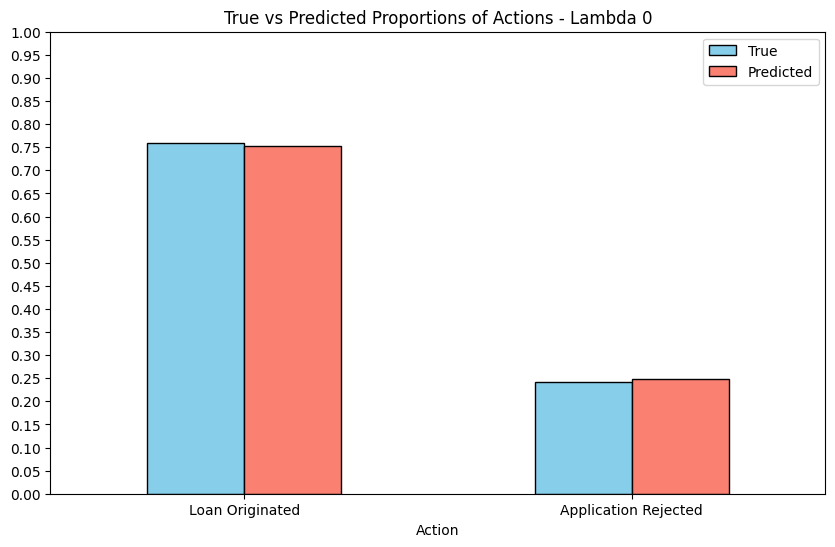

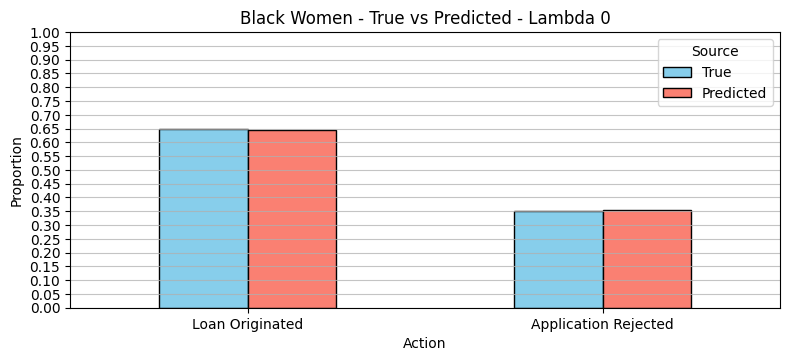

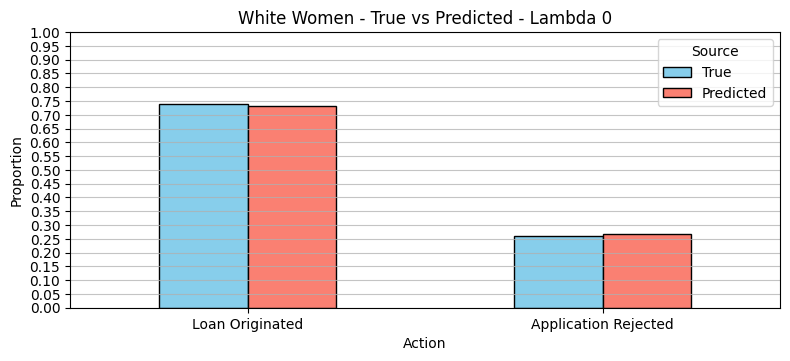

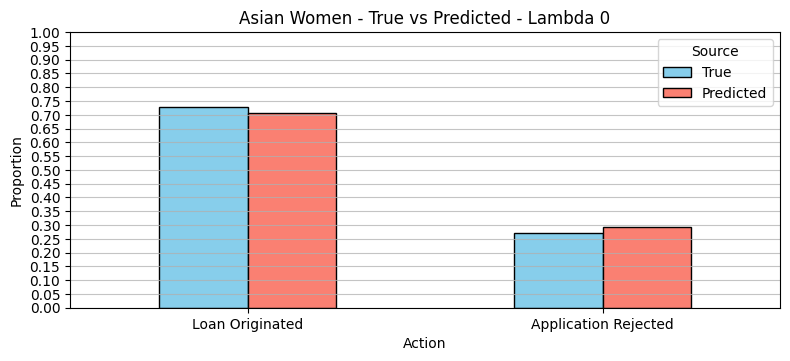

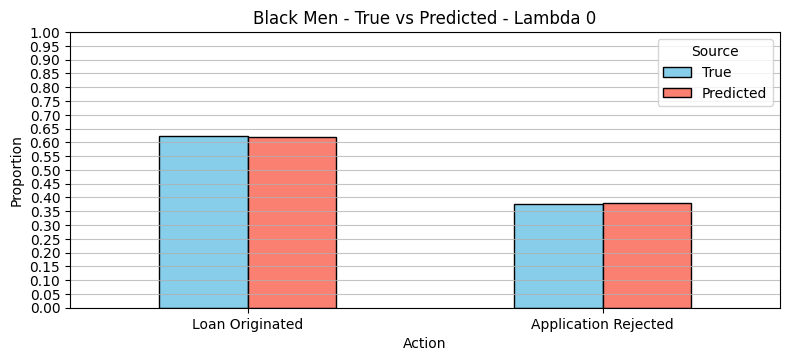

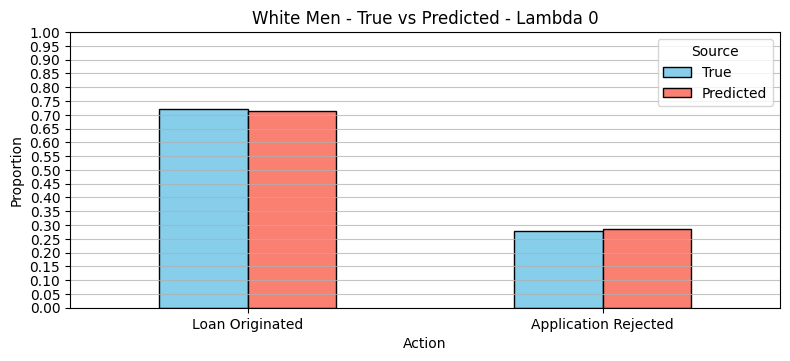

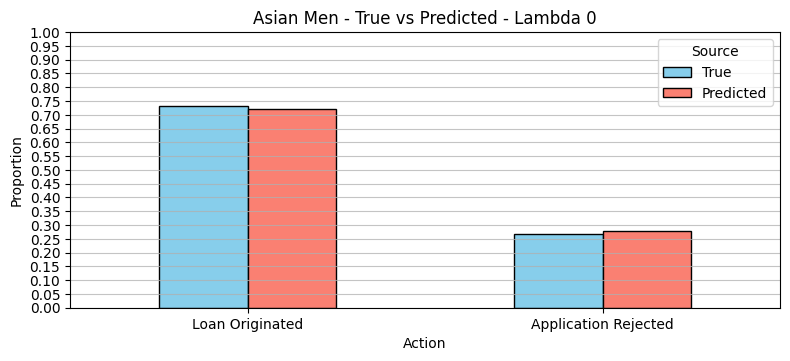

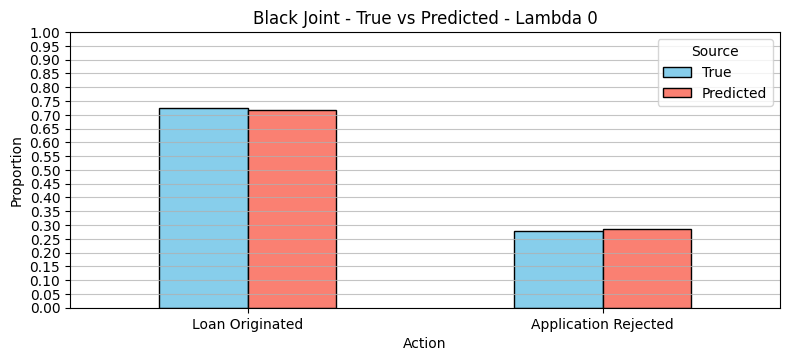

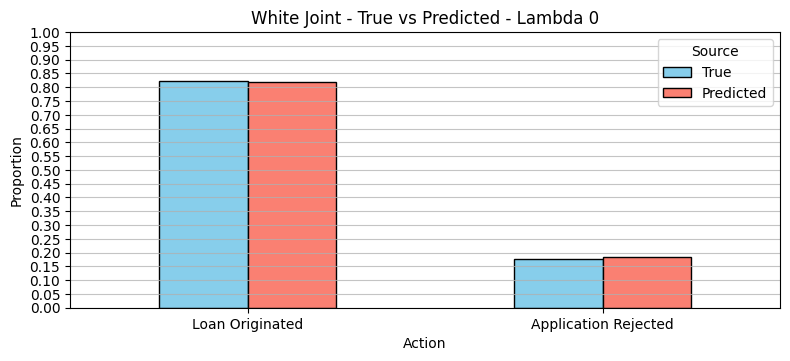

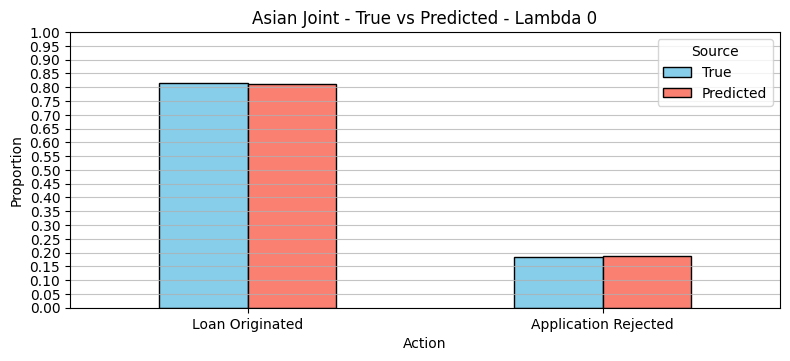

moo


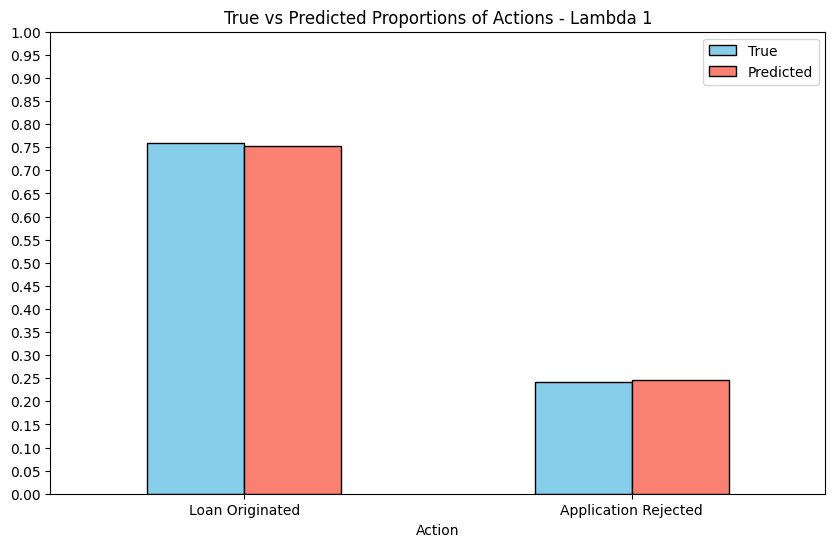

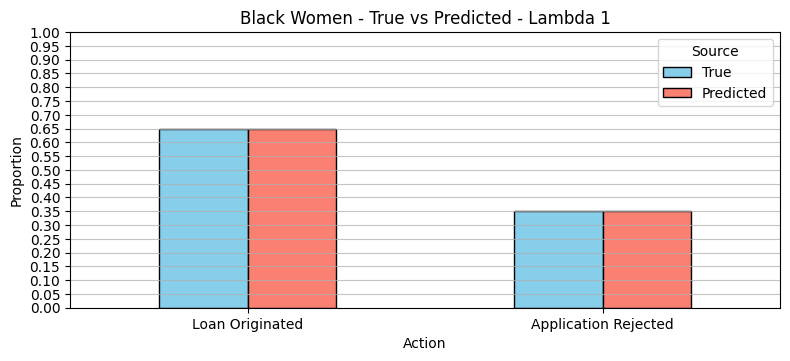

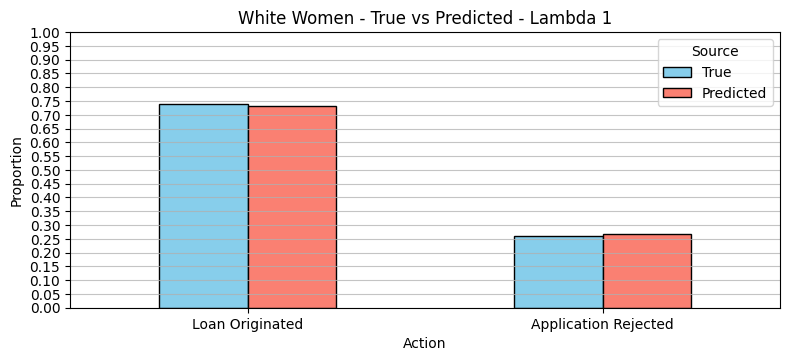

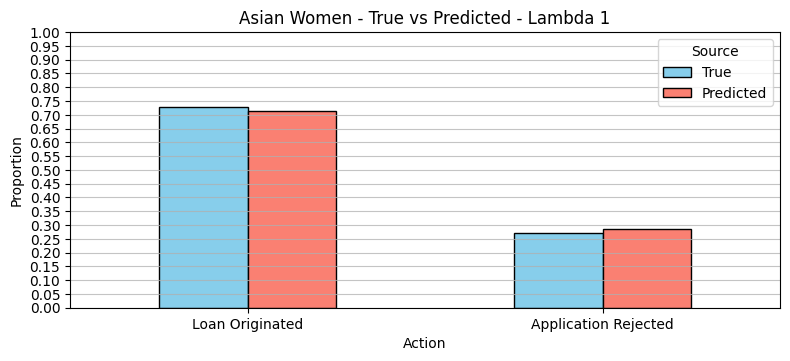

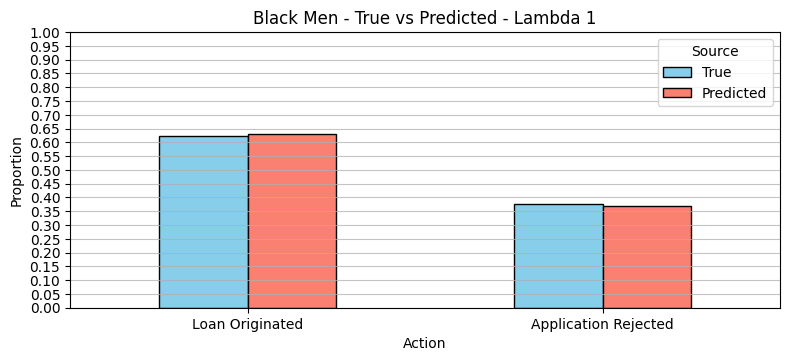

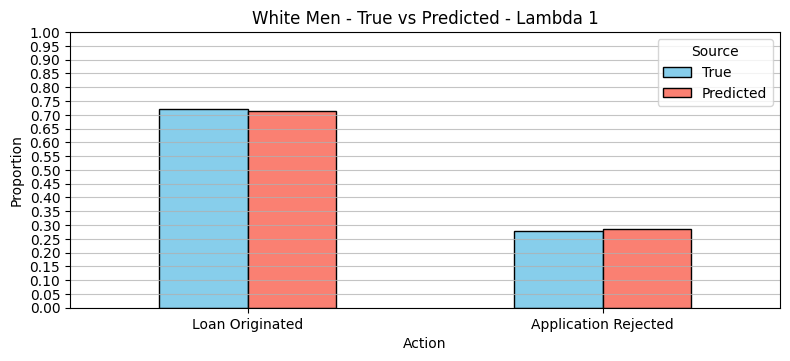

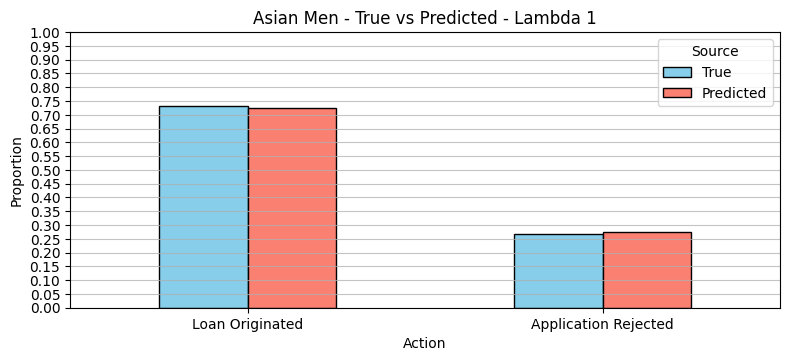

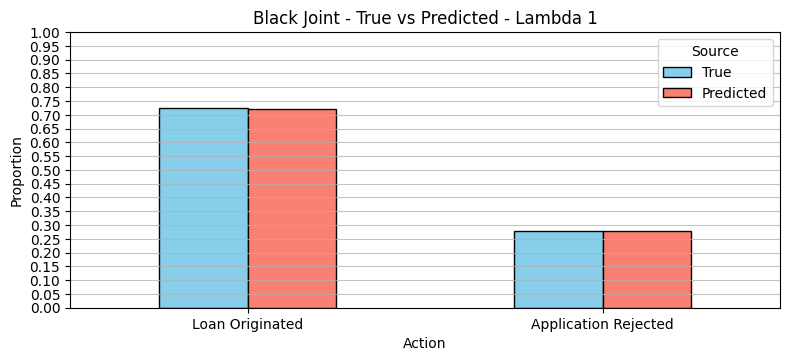

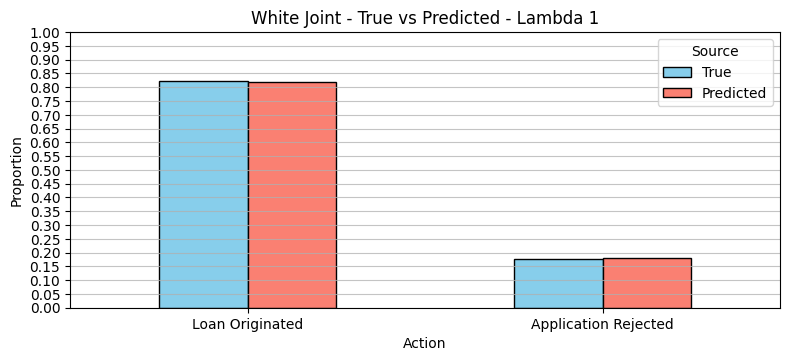

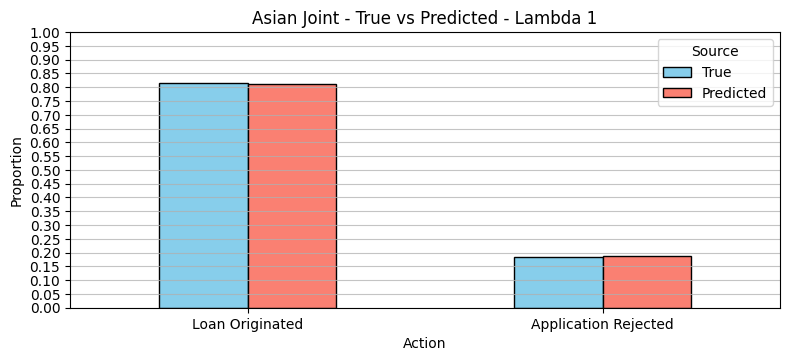

moo


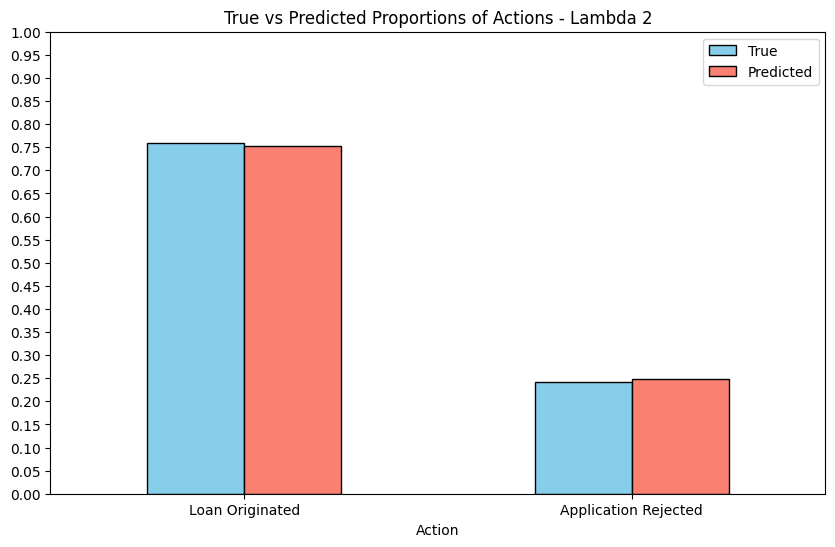

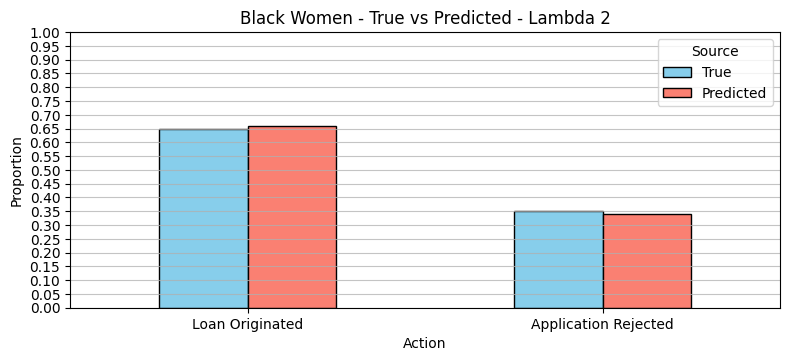

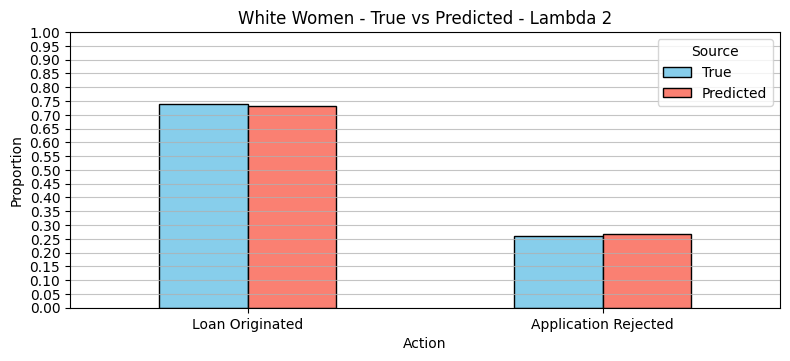

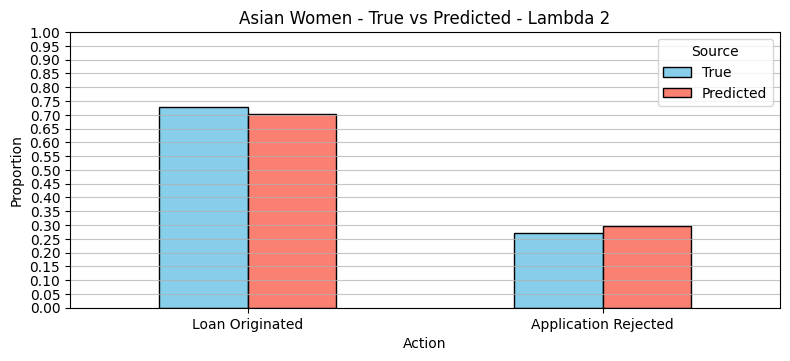

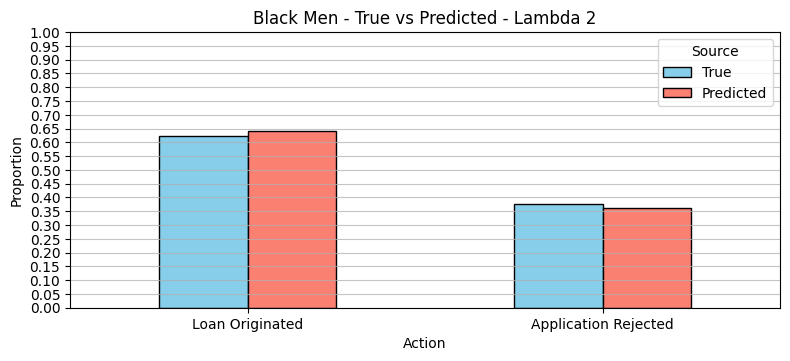

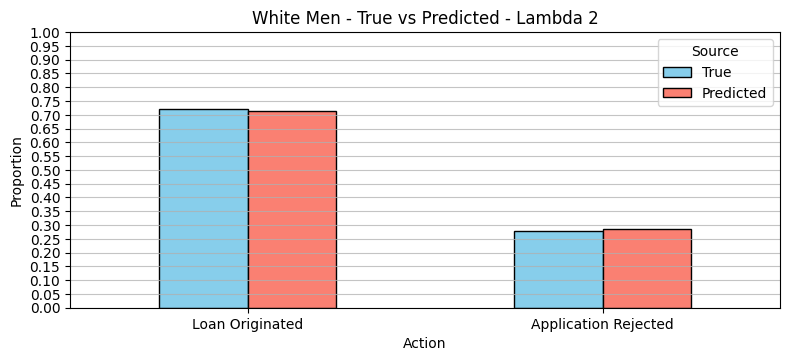

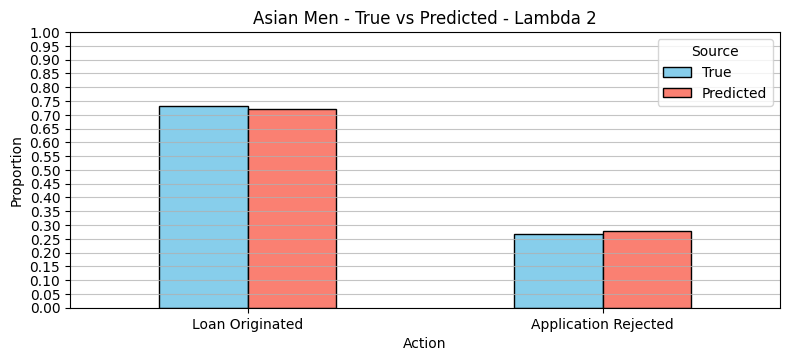

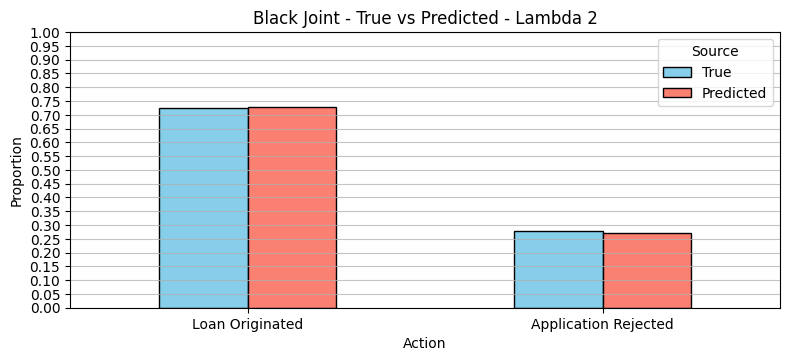

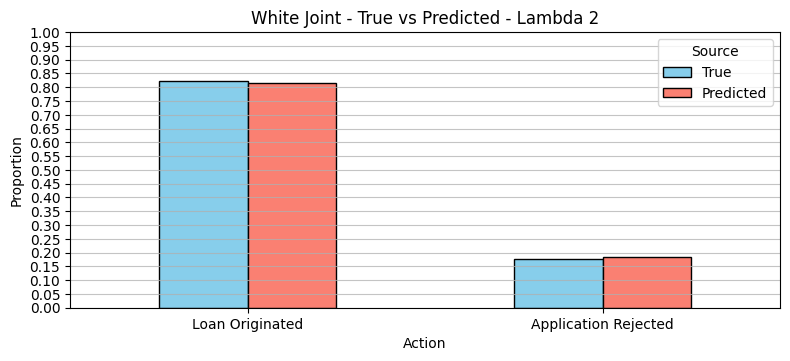

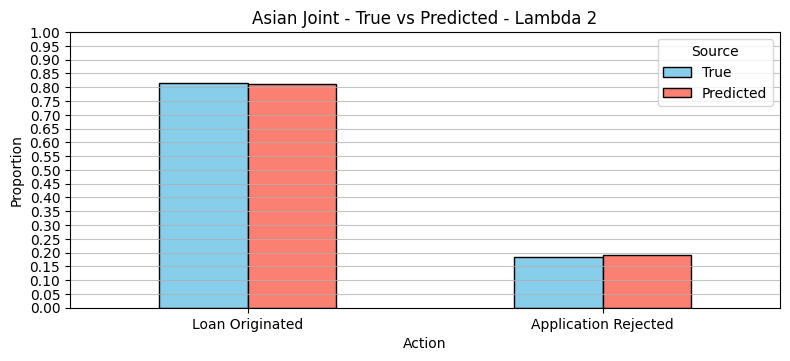

moo


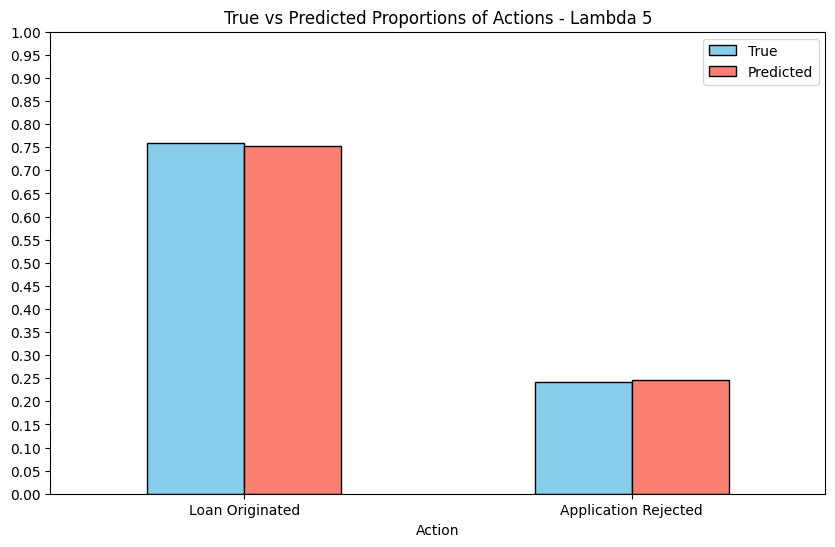

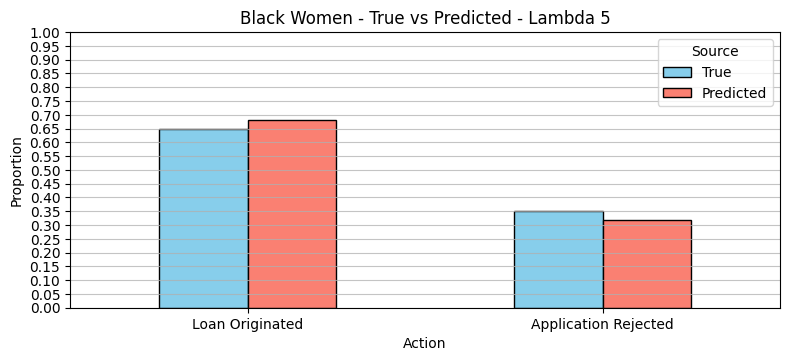

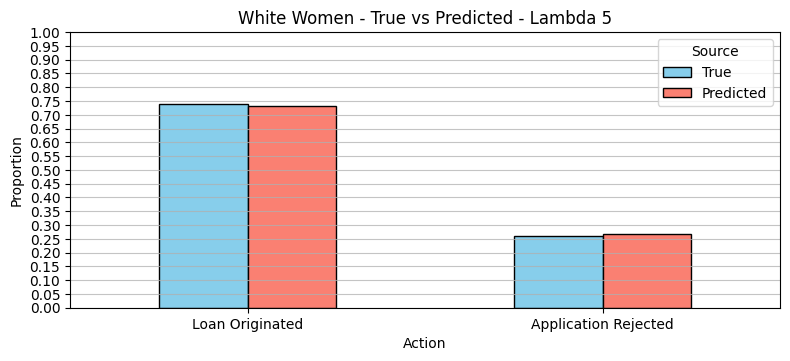

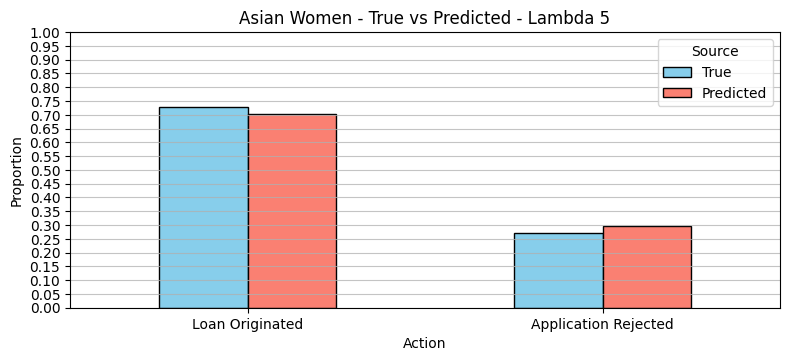

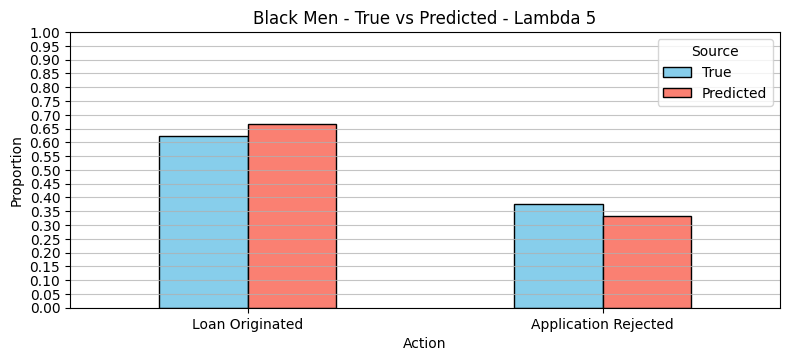

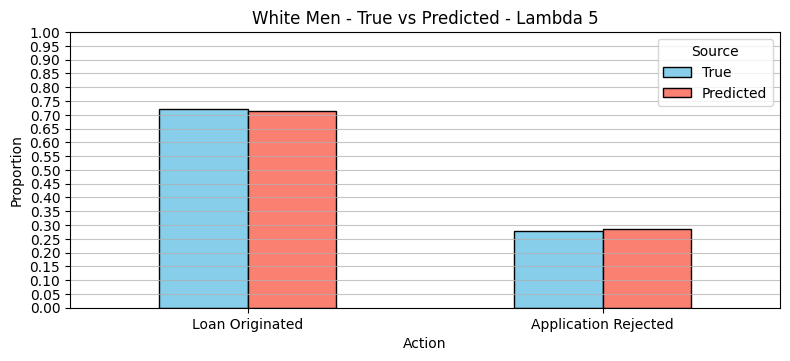

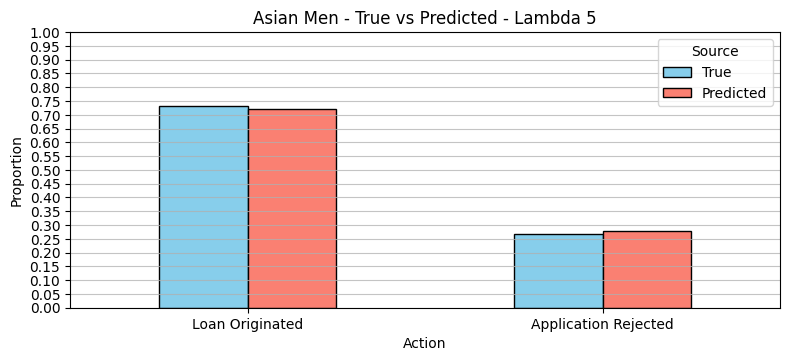

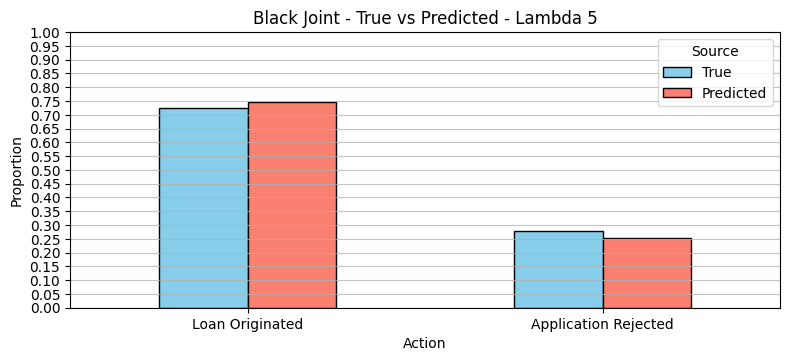

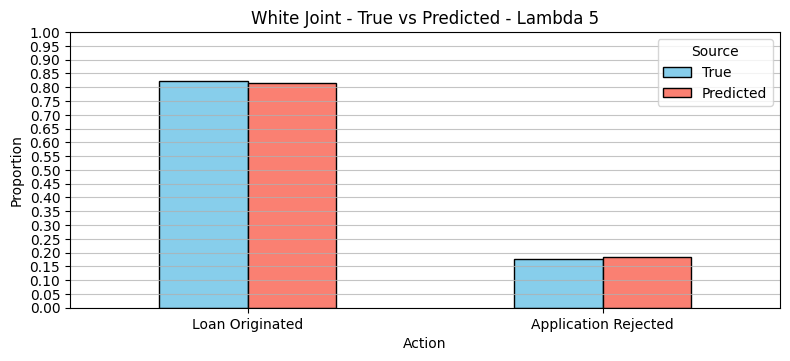

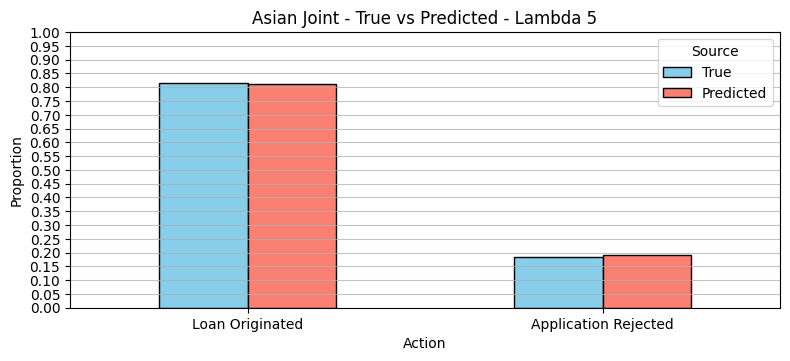

moo


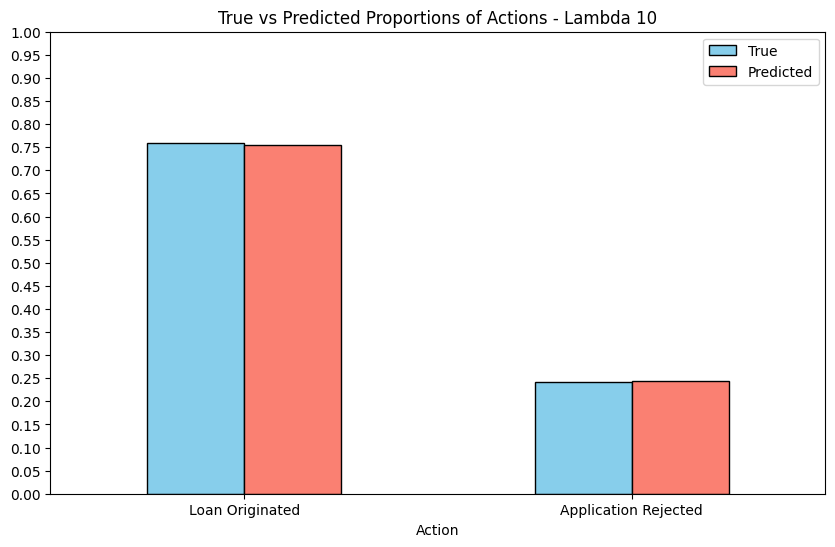

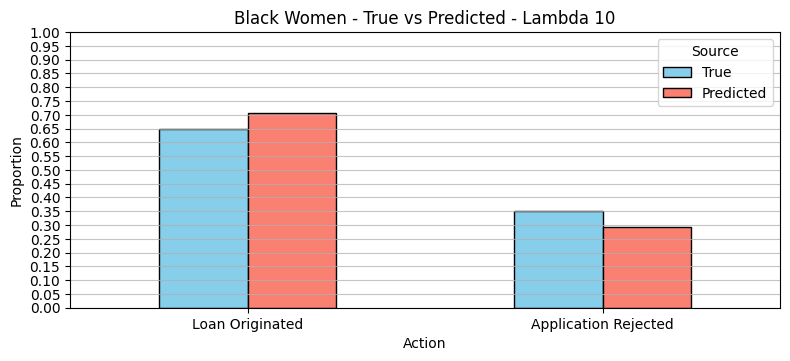

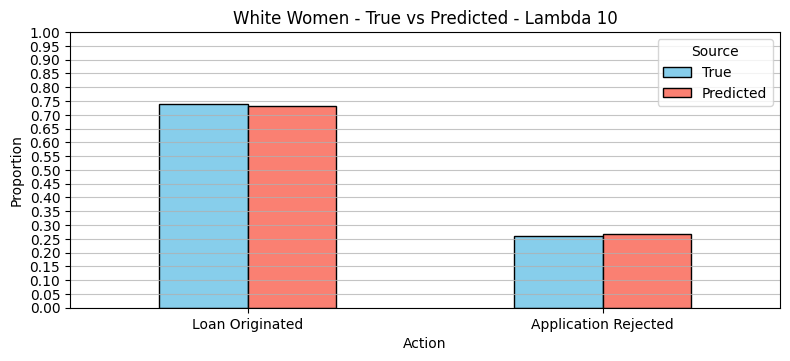

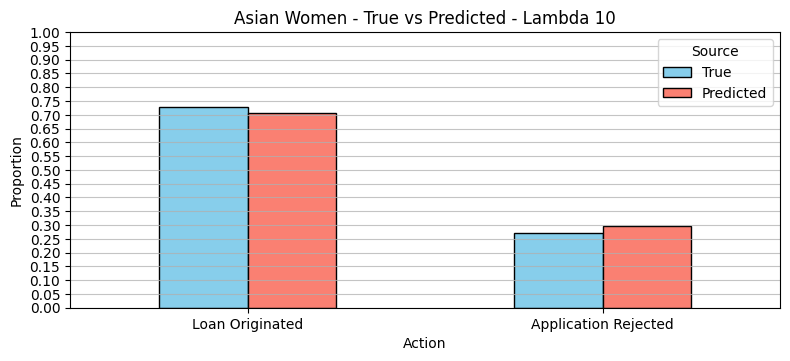

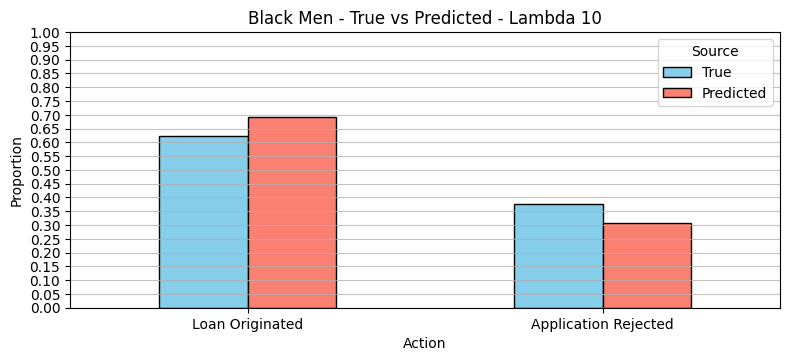

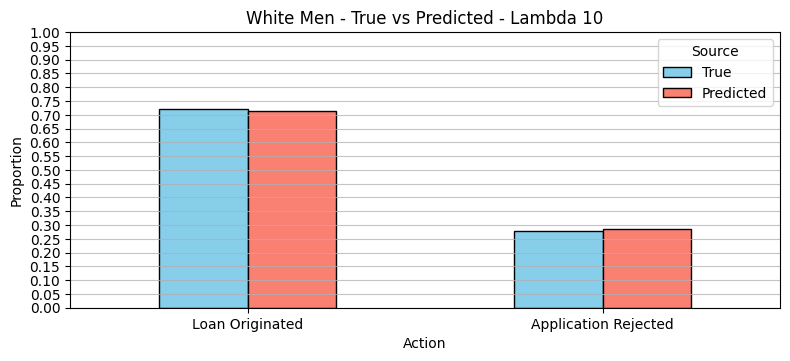

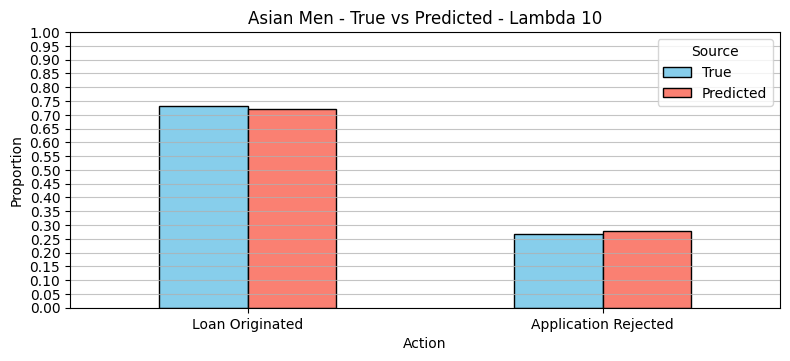

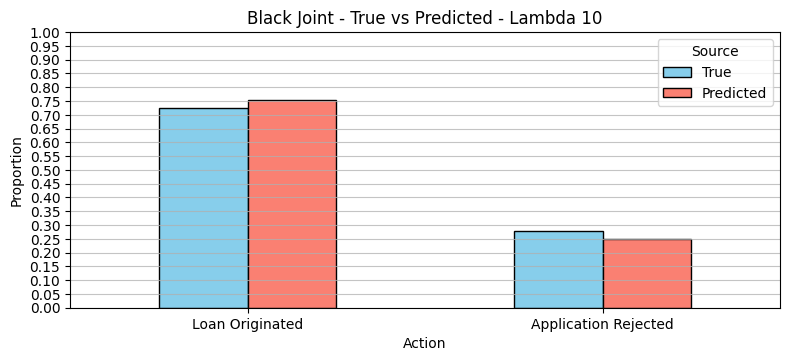

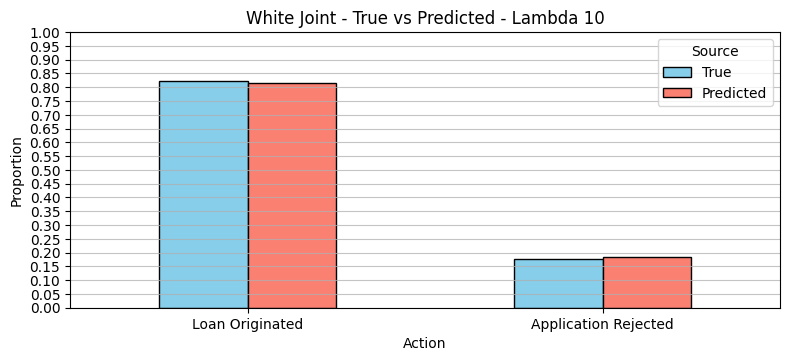

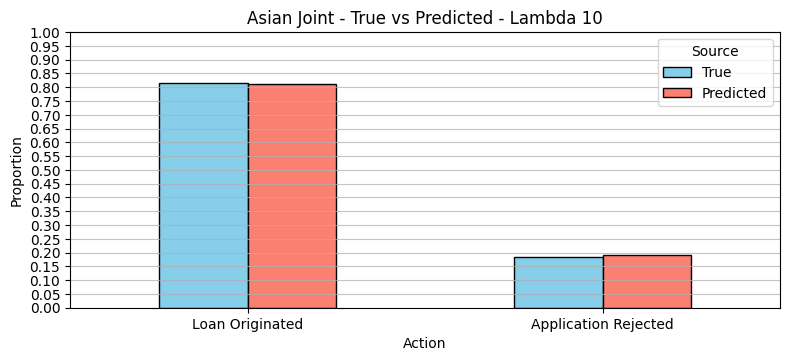

moo


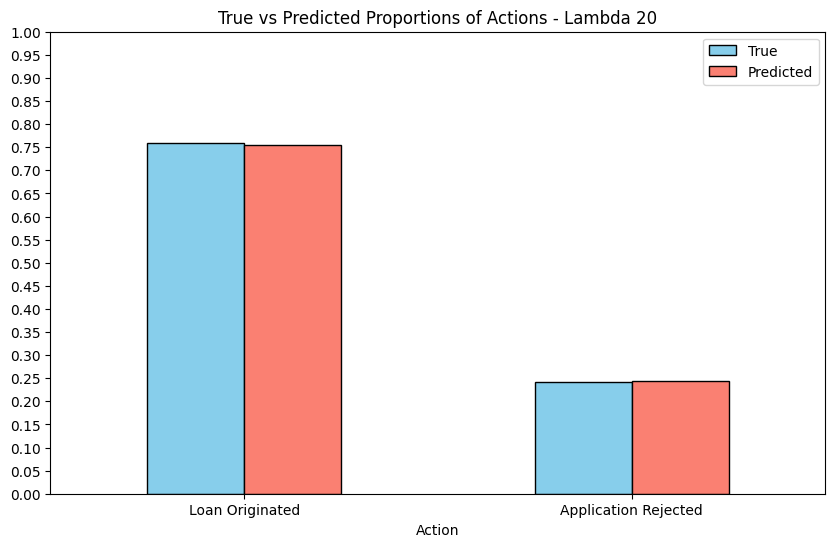

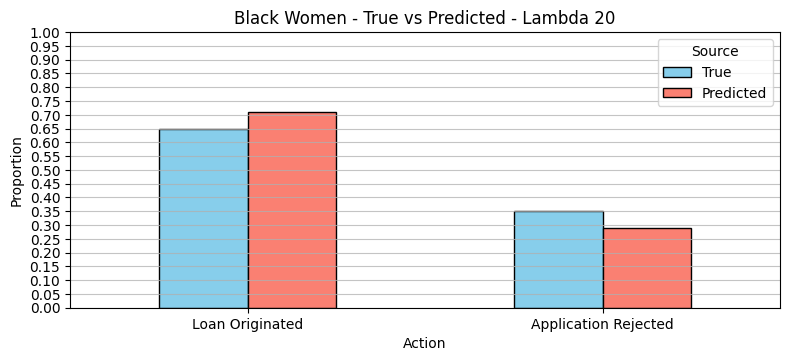

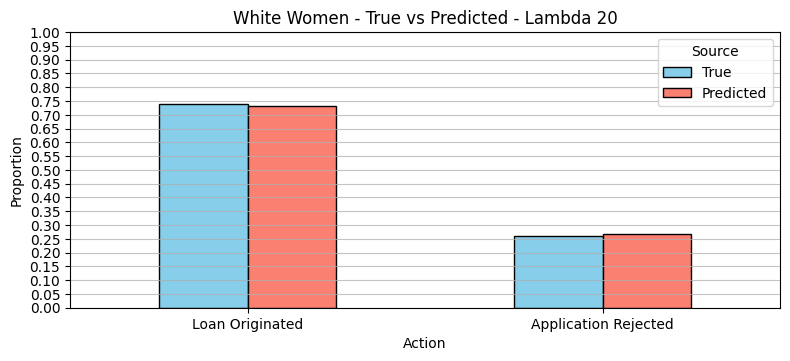

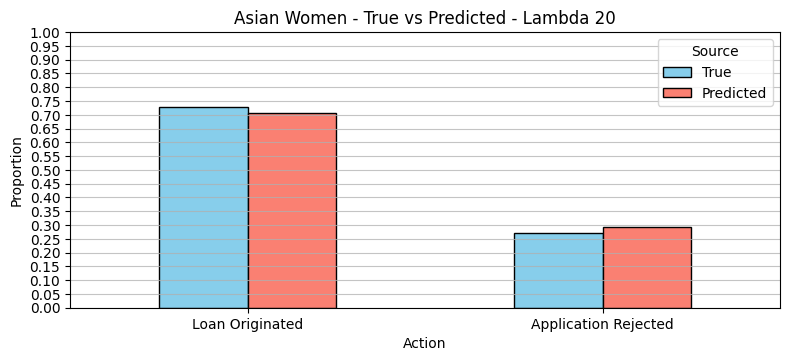

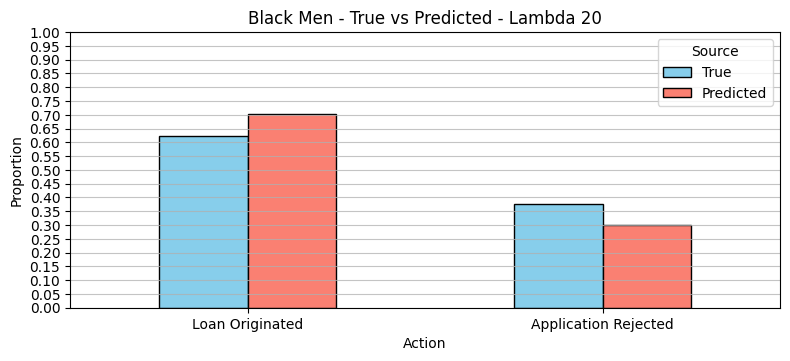

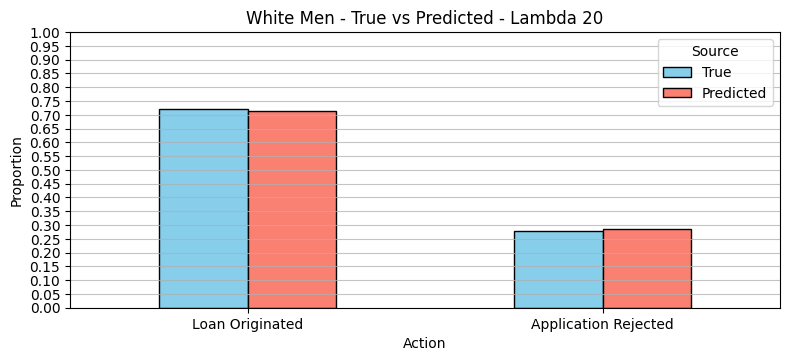

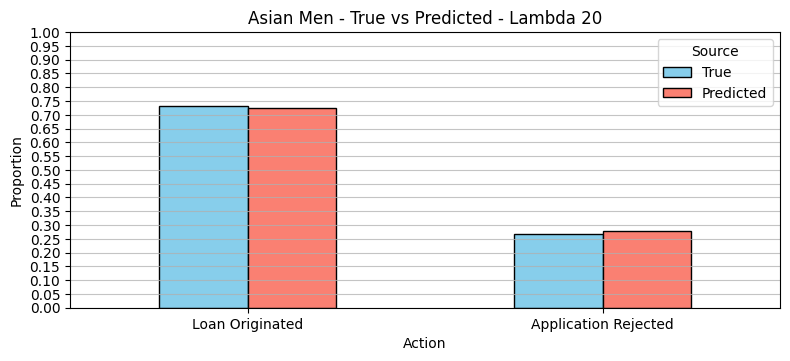

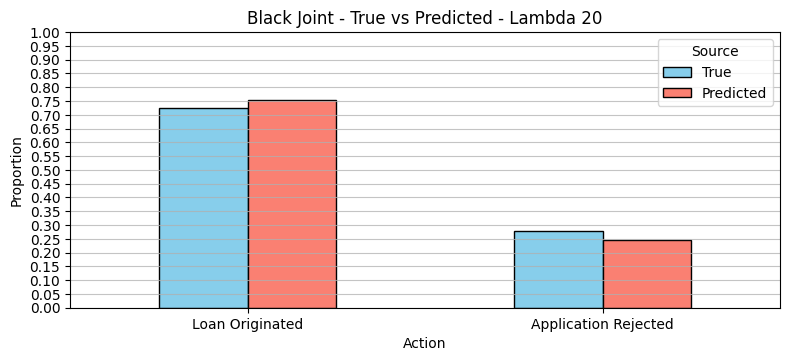

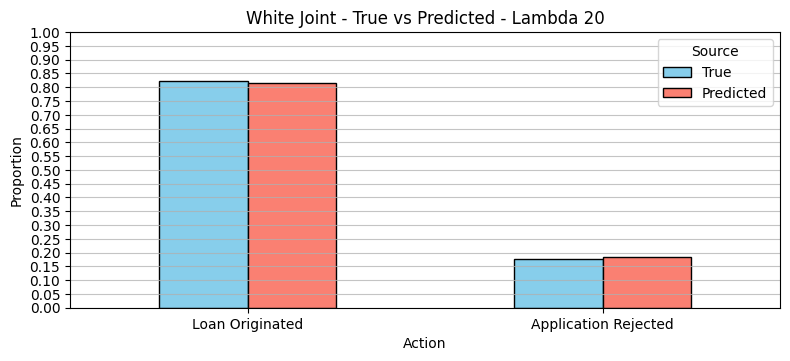

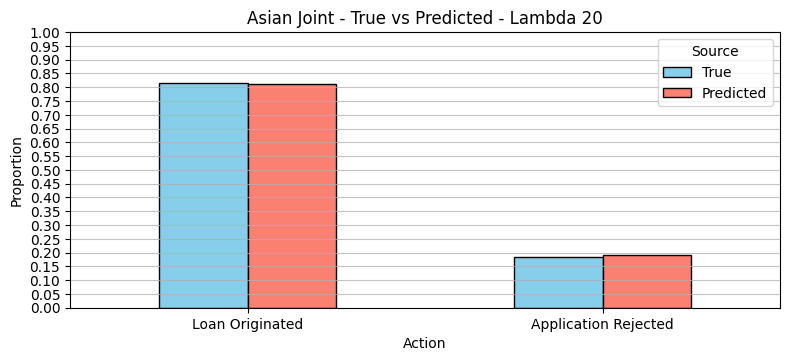

moo


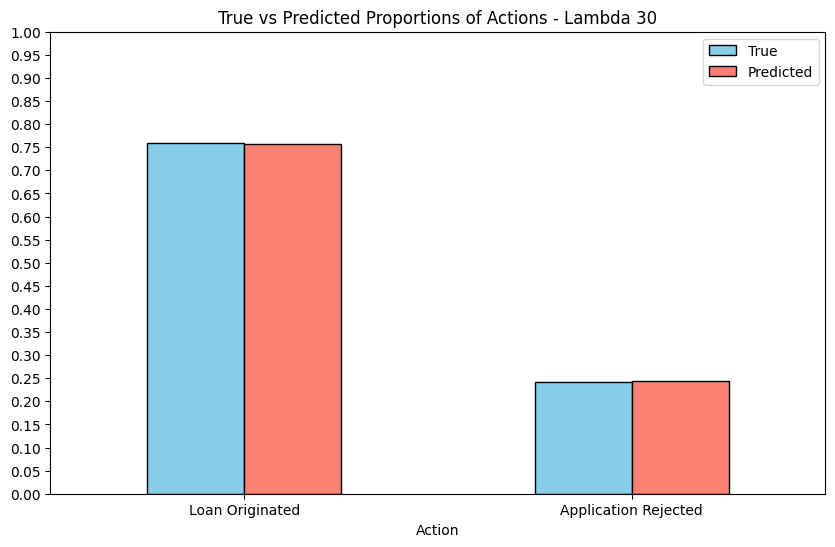

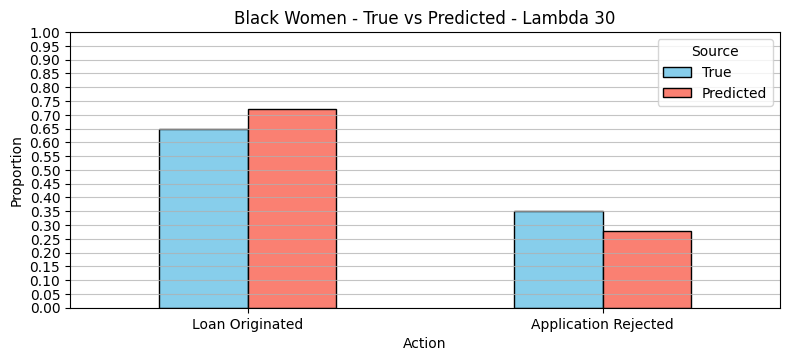

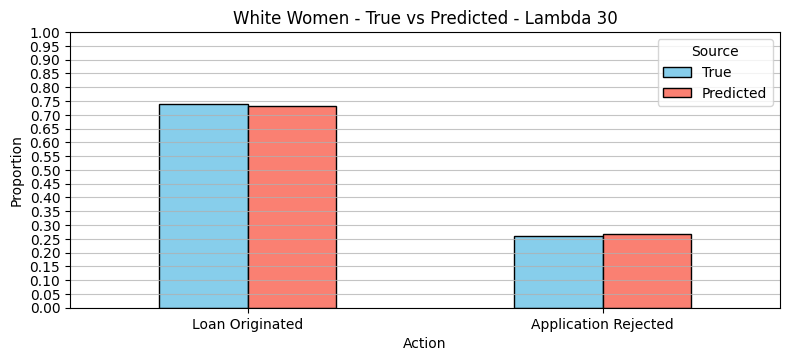

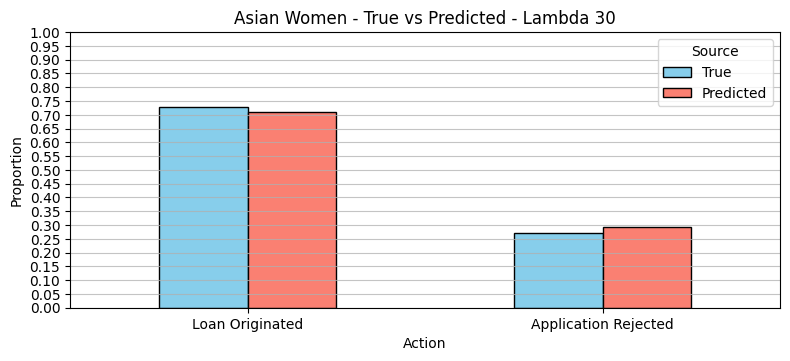

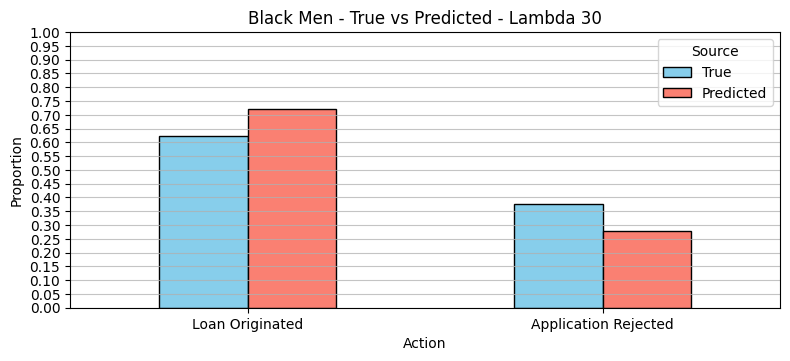

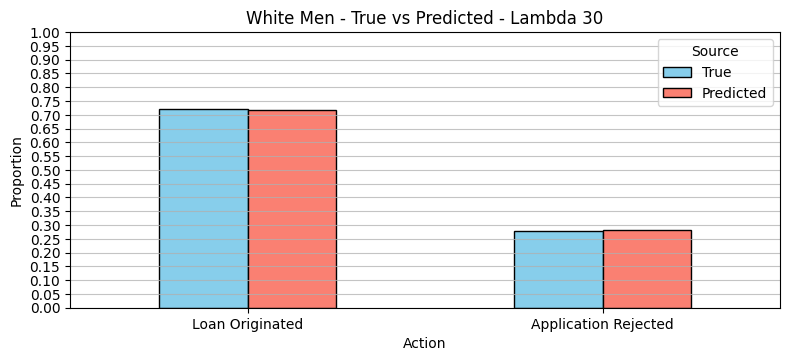

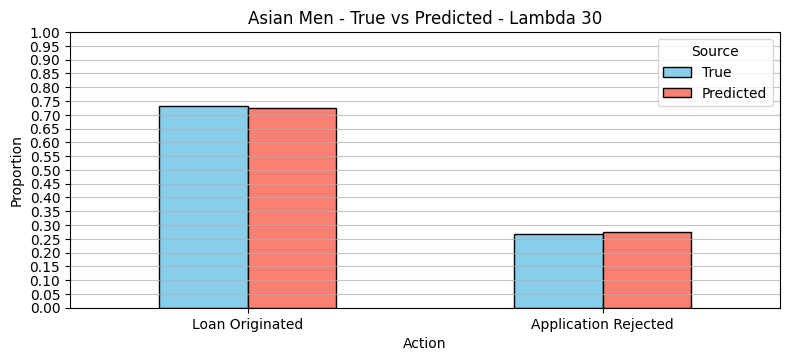

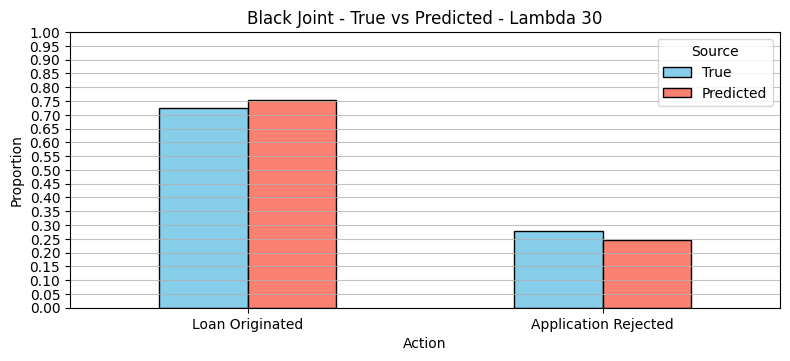

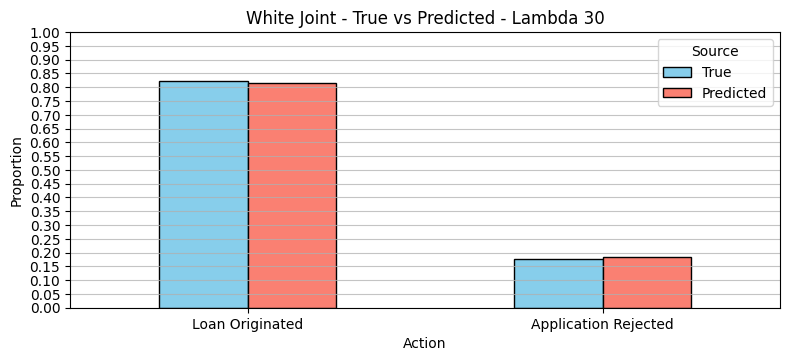

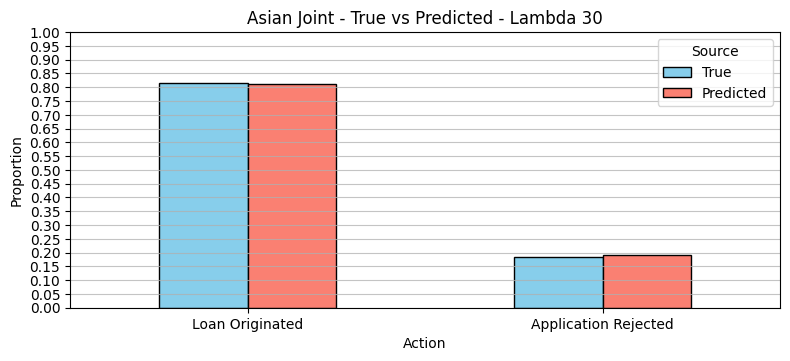

moo


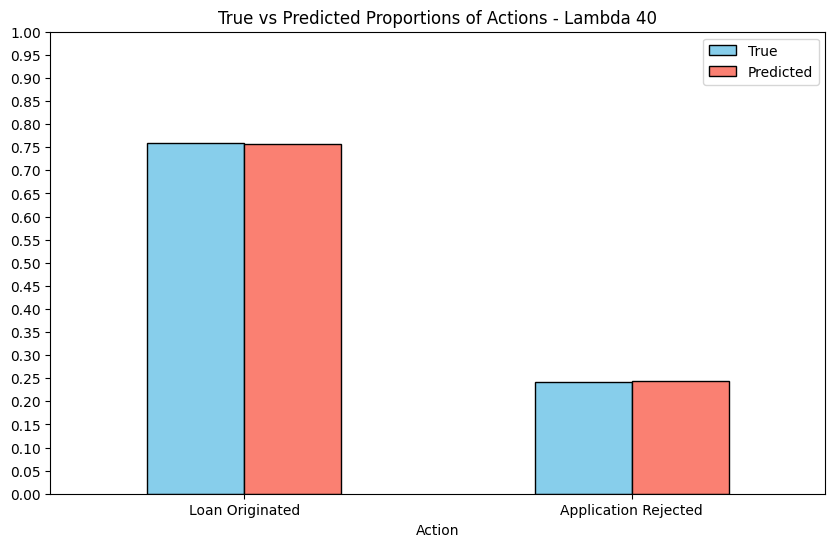

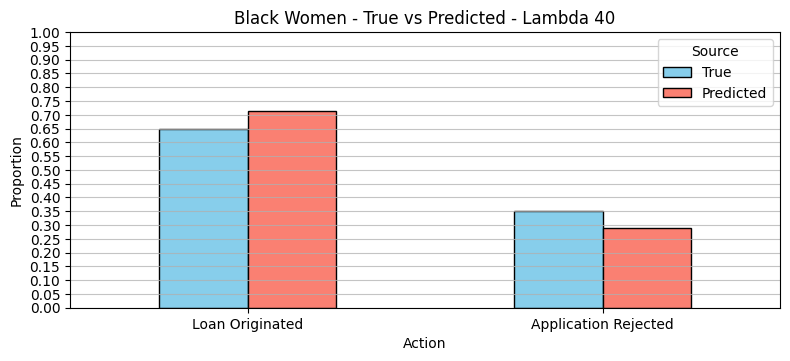

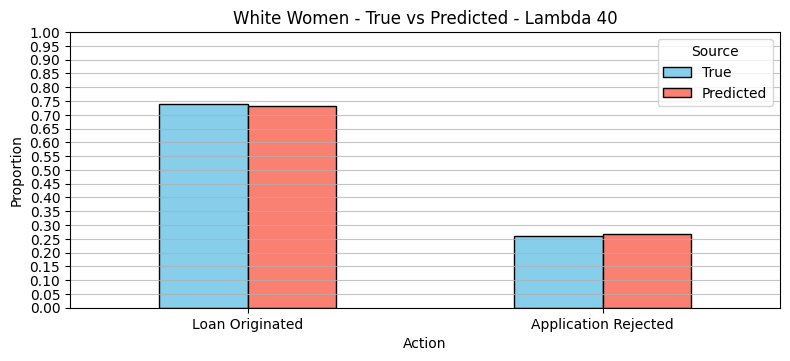

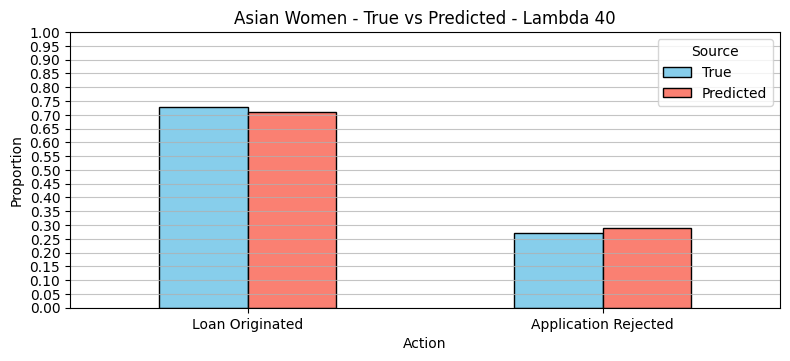

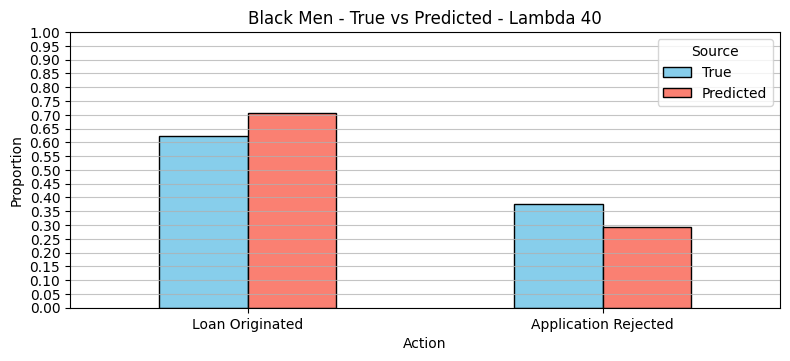

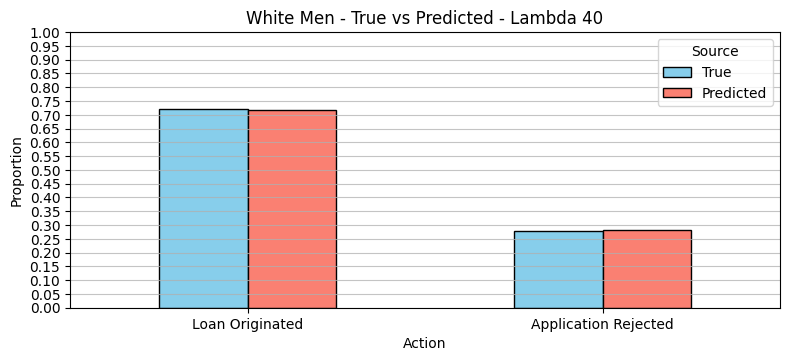

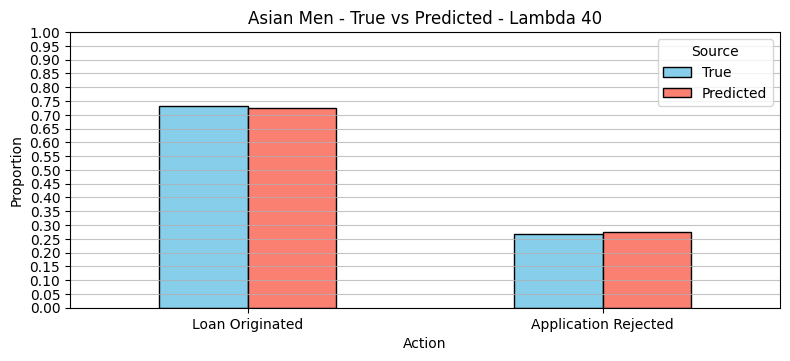

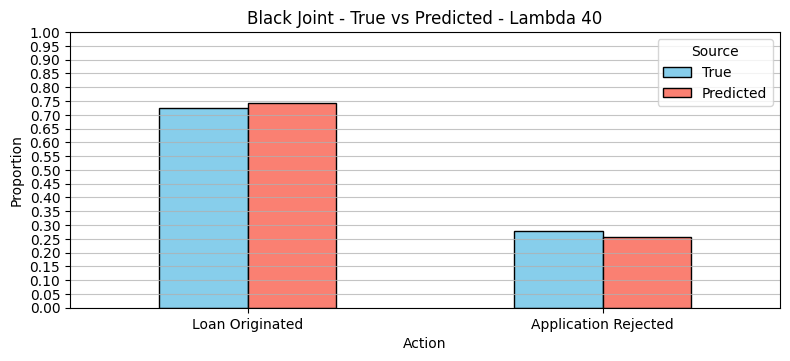

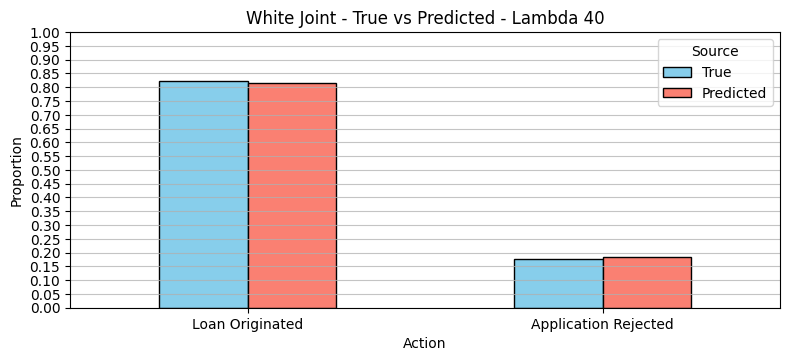

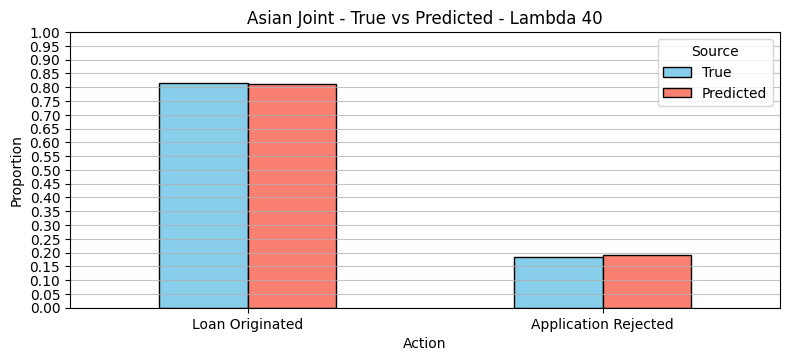

moo


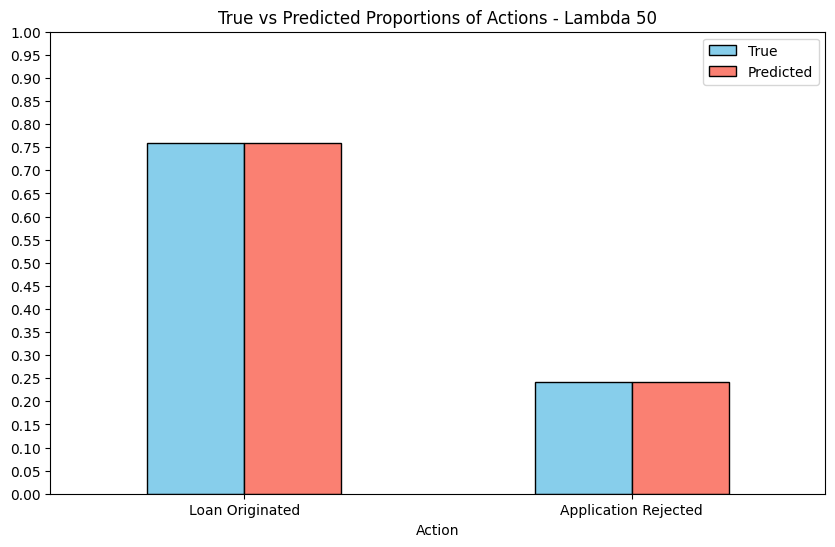

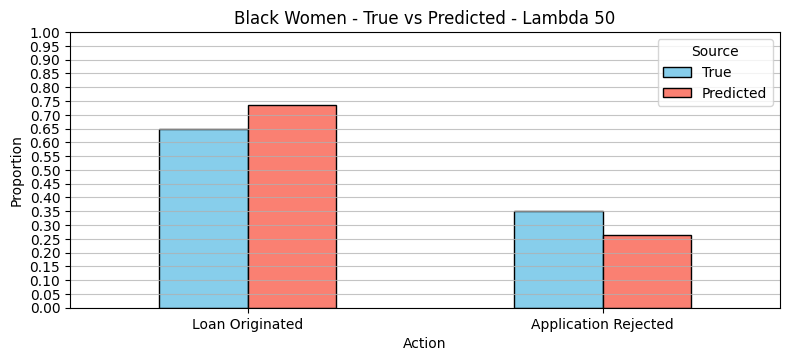

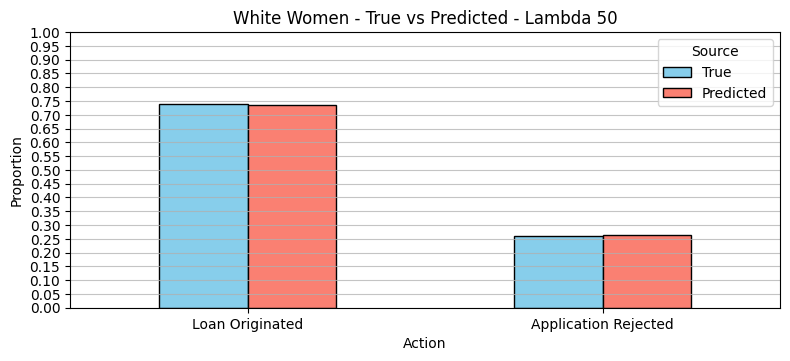

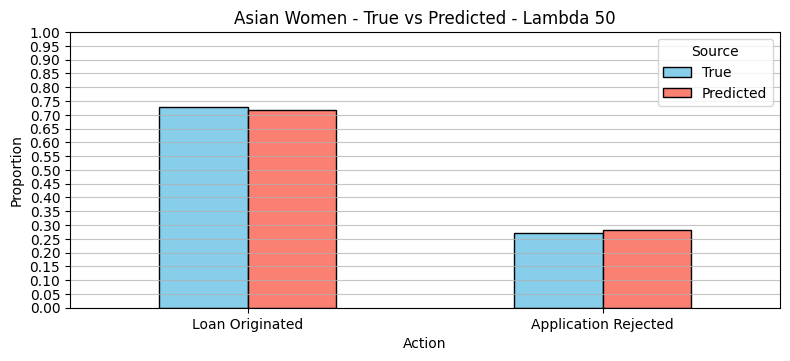

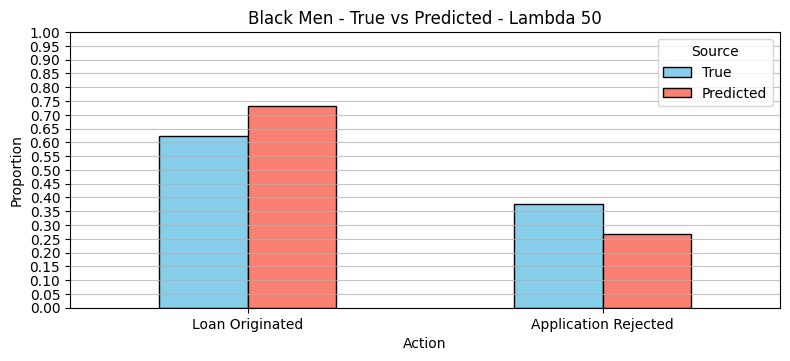

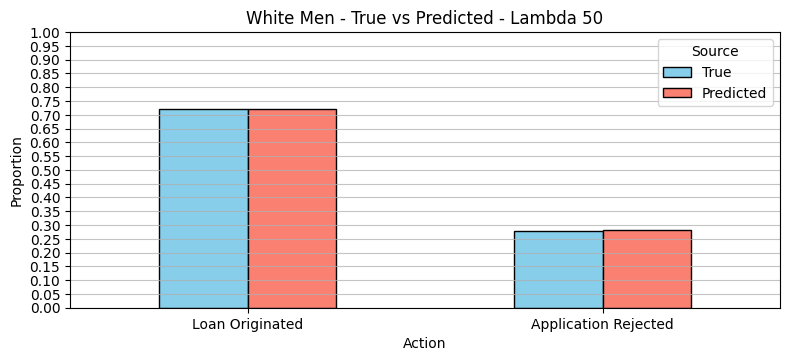

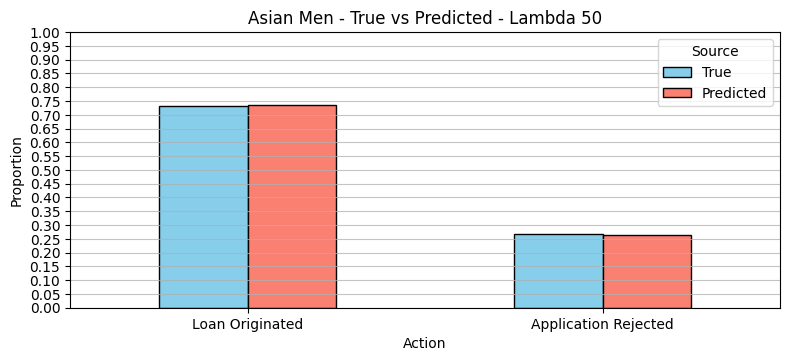

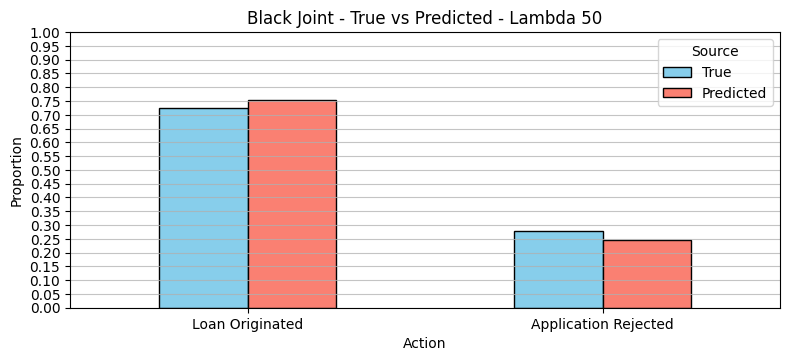

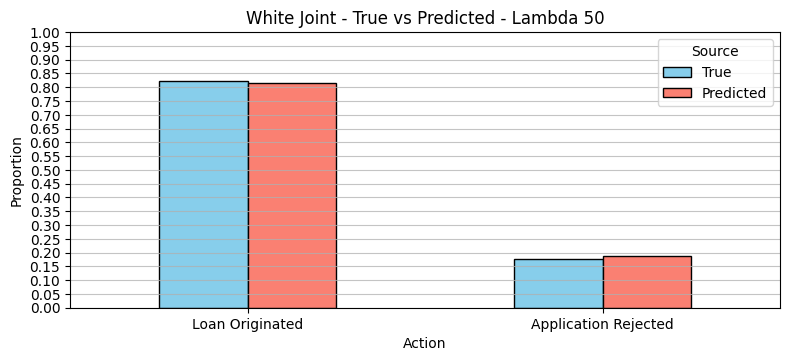

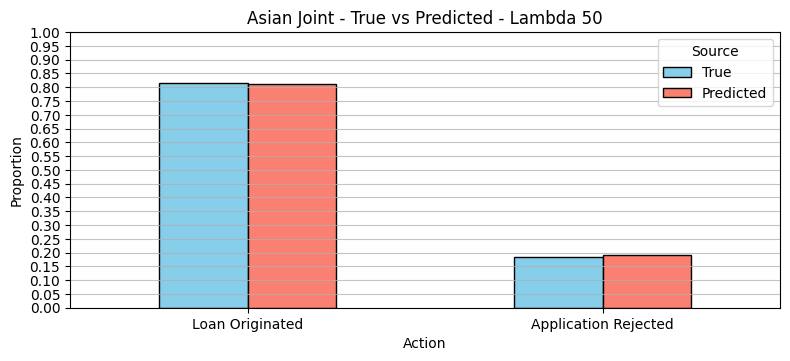

moo


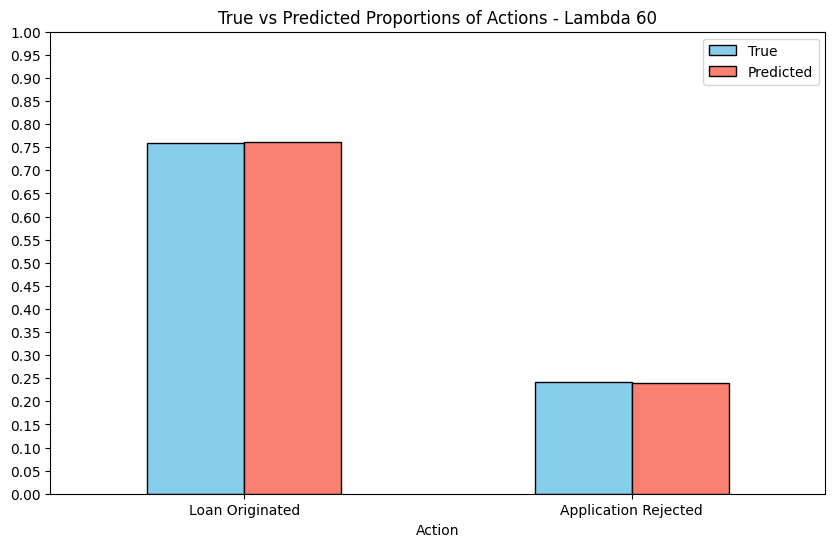

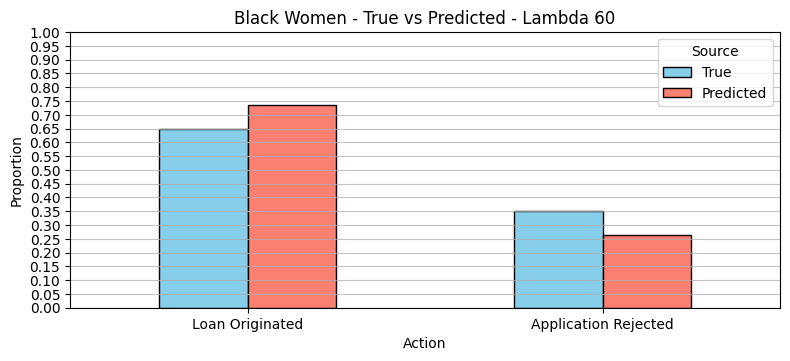

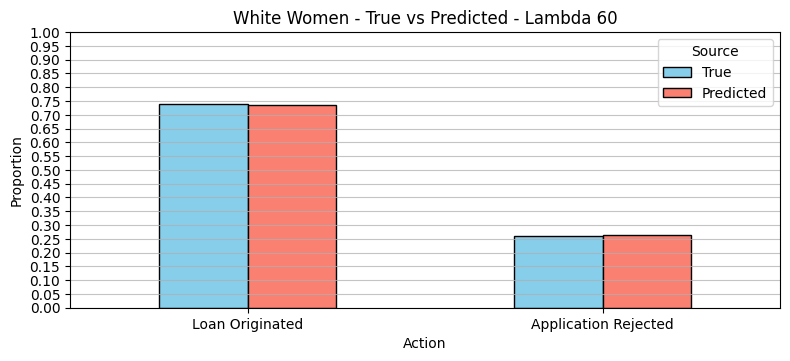

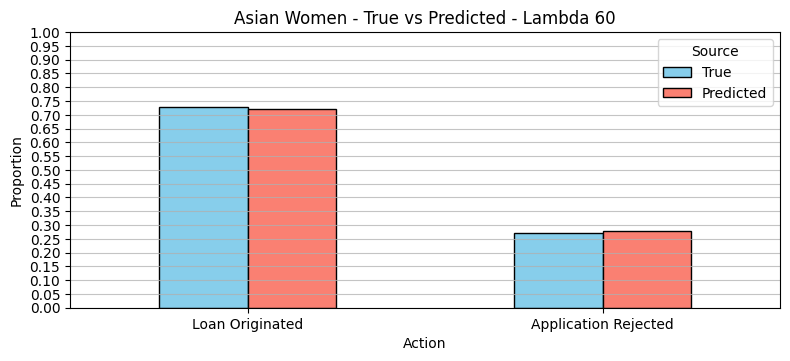

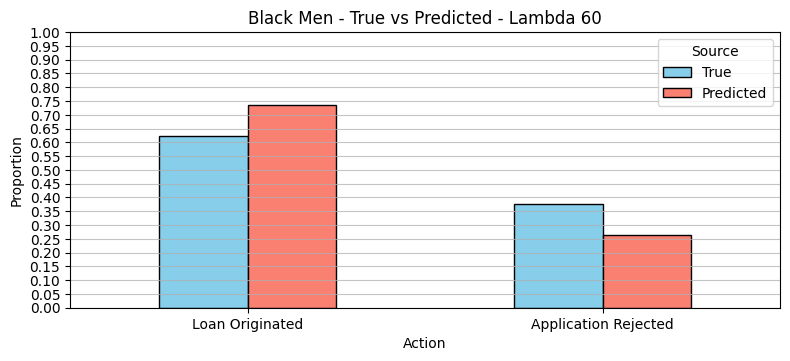

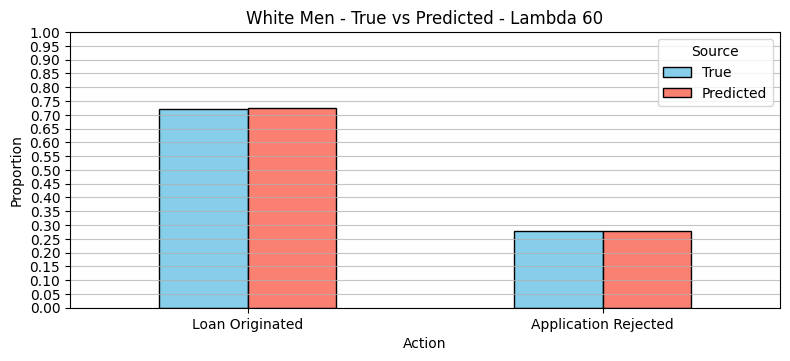

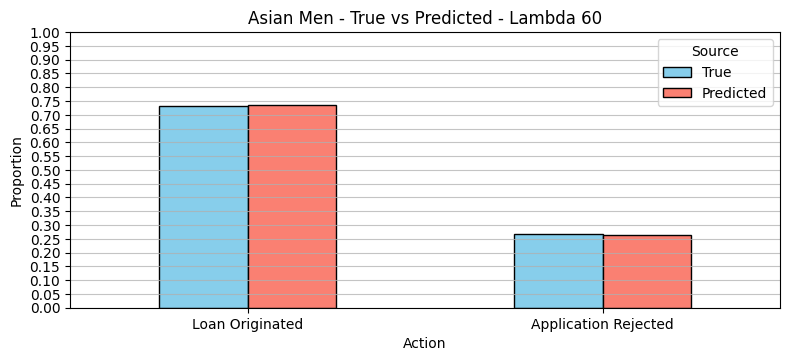

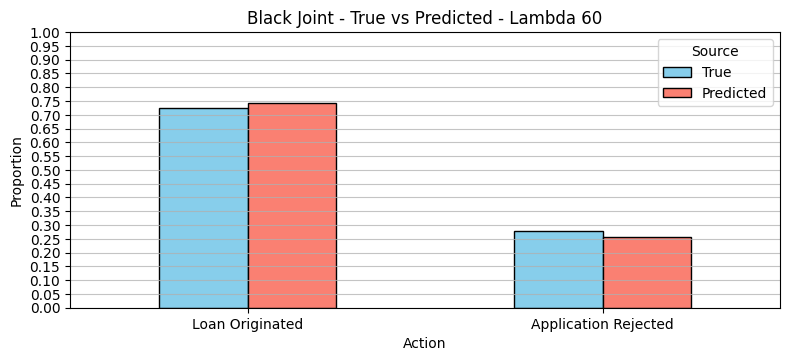

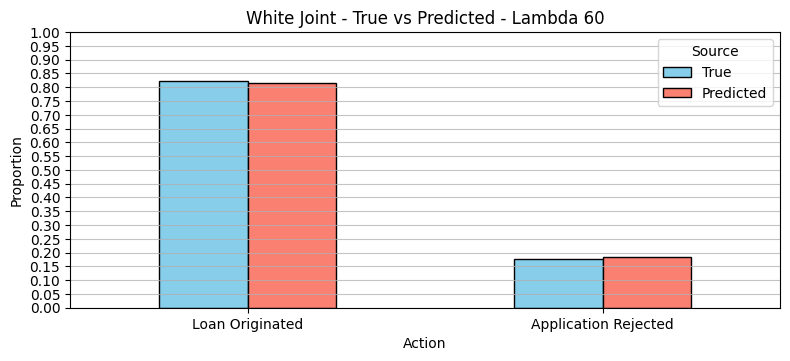

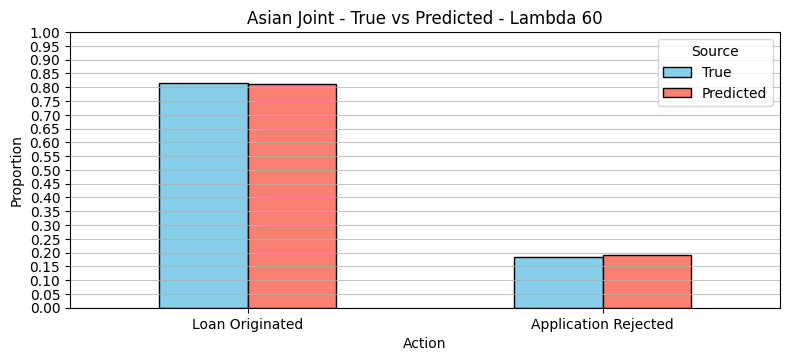

moo


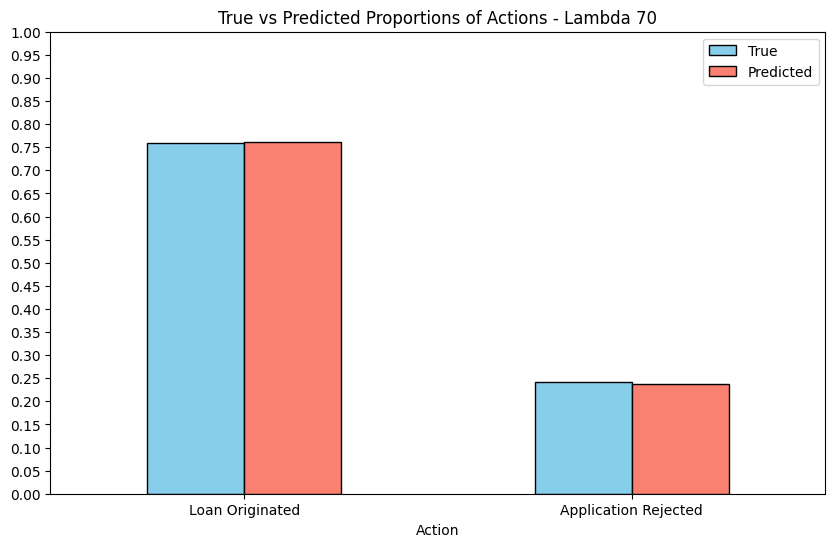

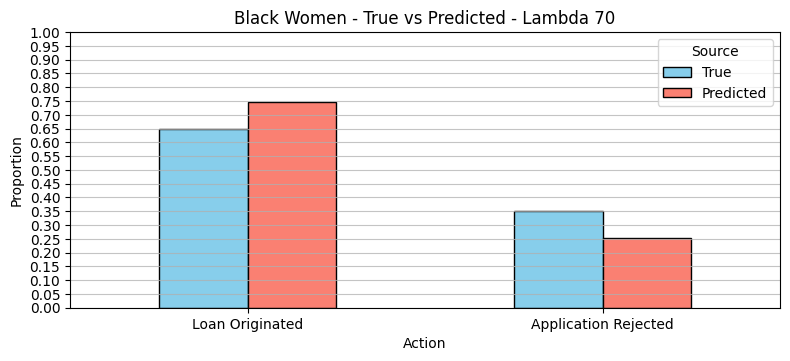

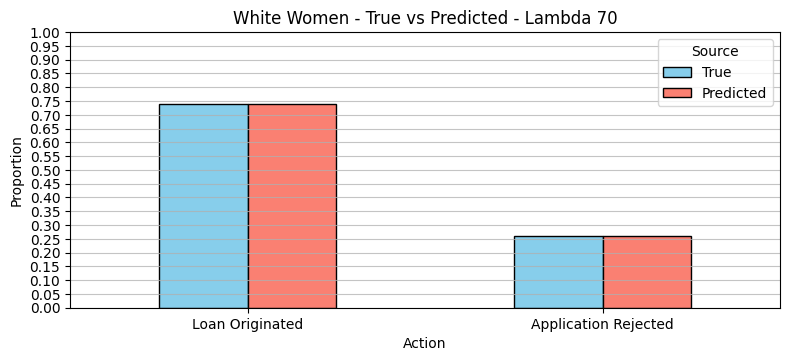

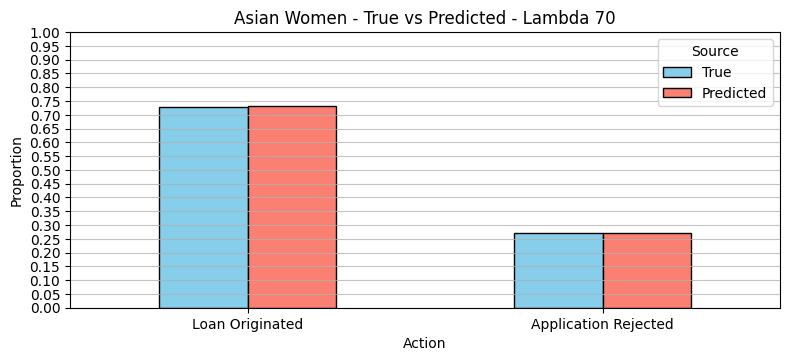

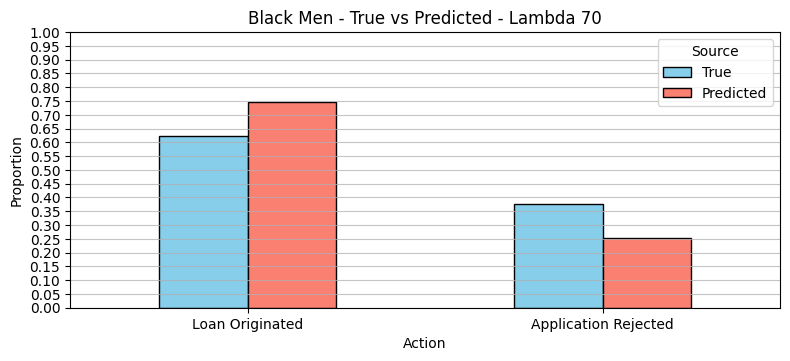

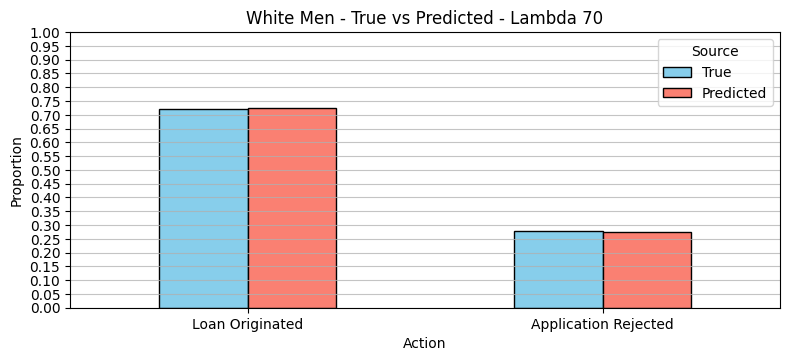

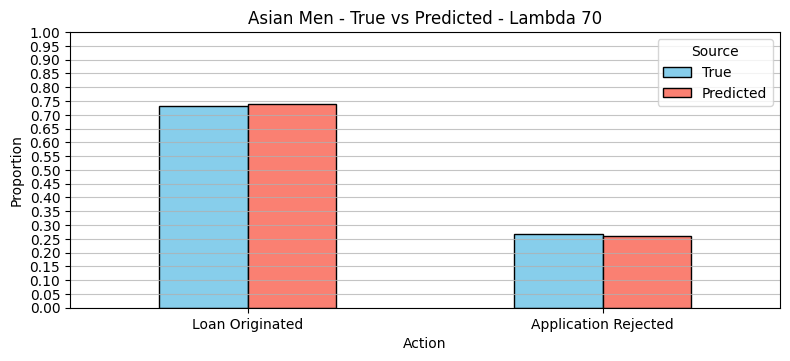

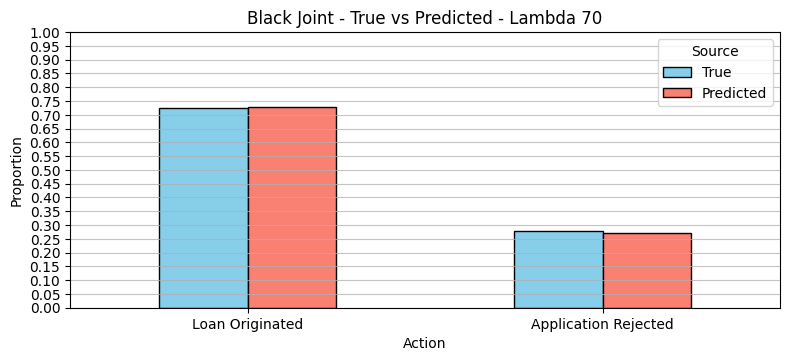

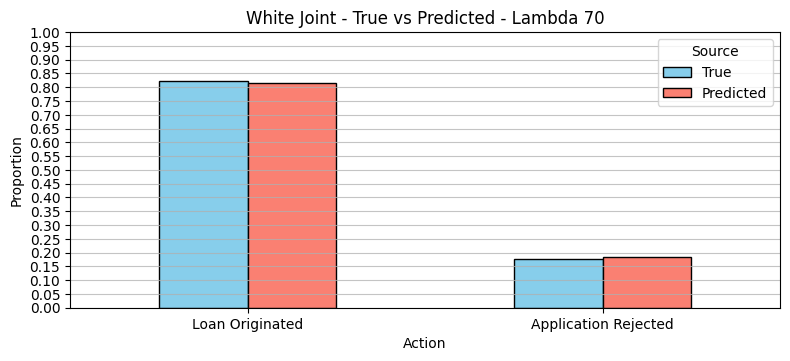

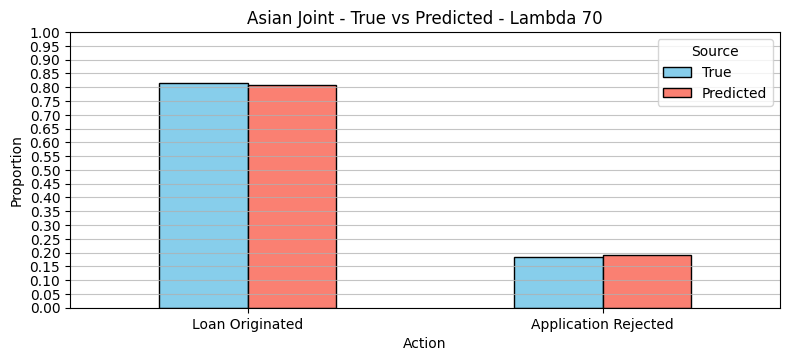

moo


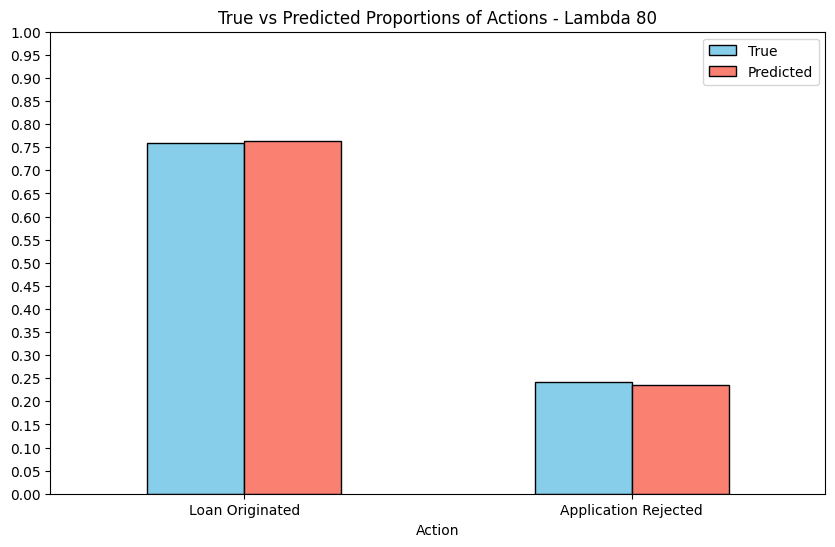

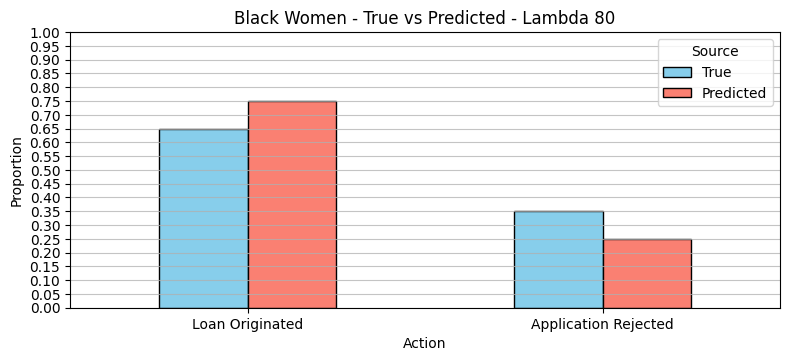

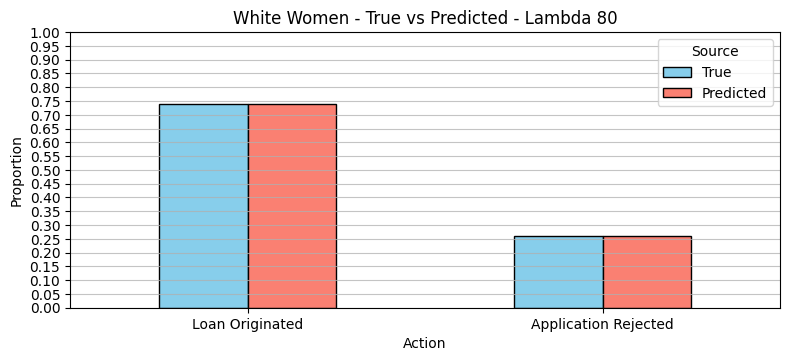

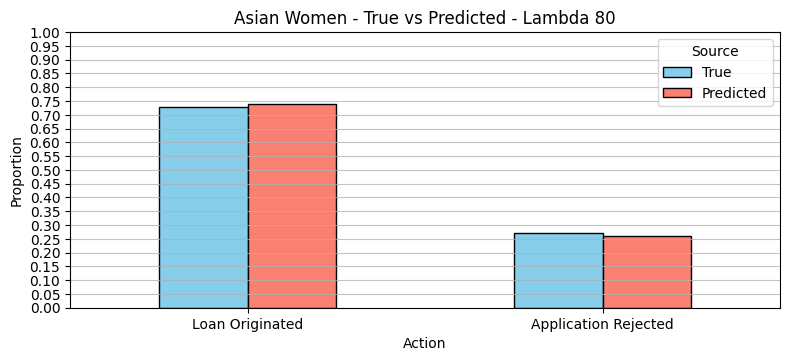

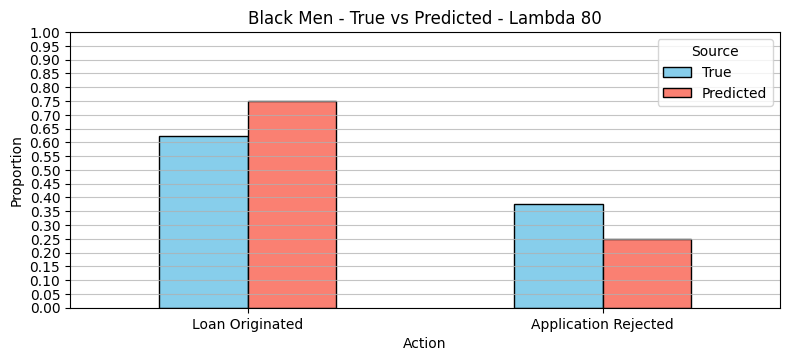

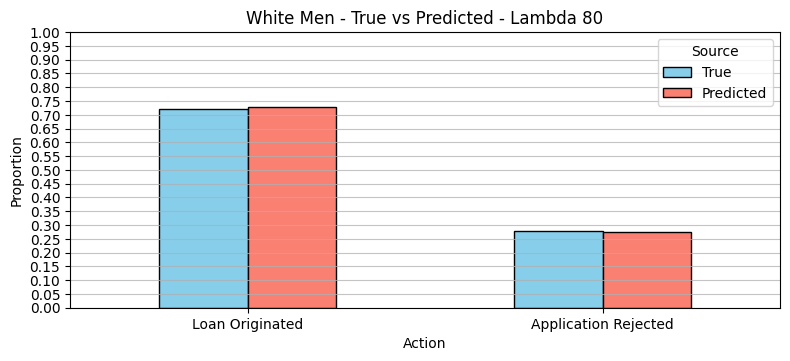

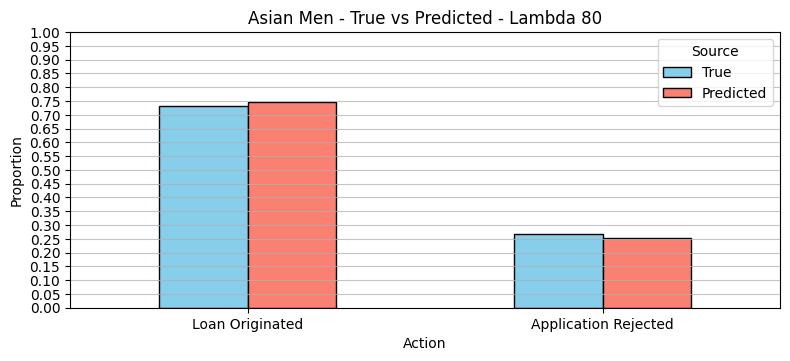

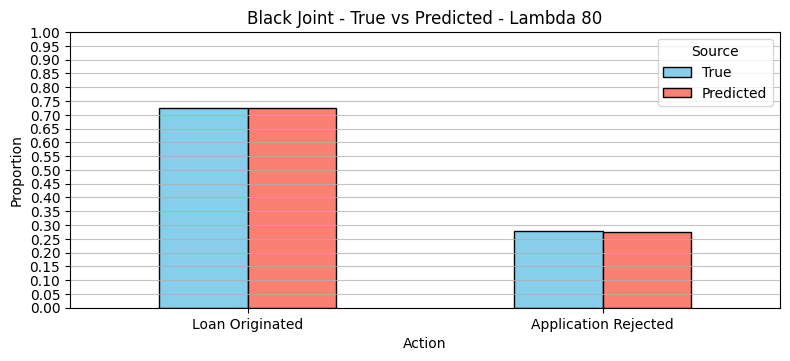

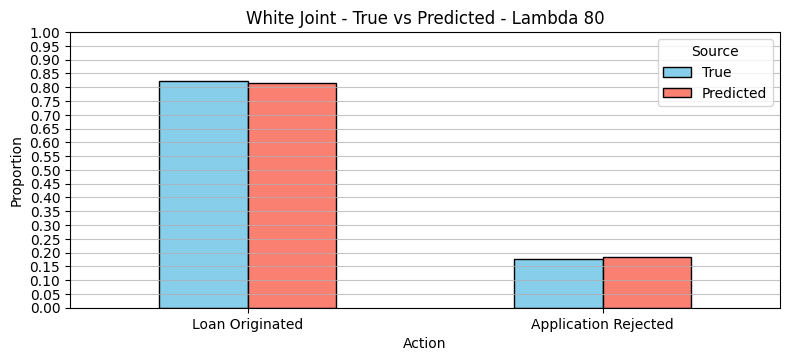

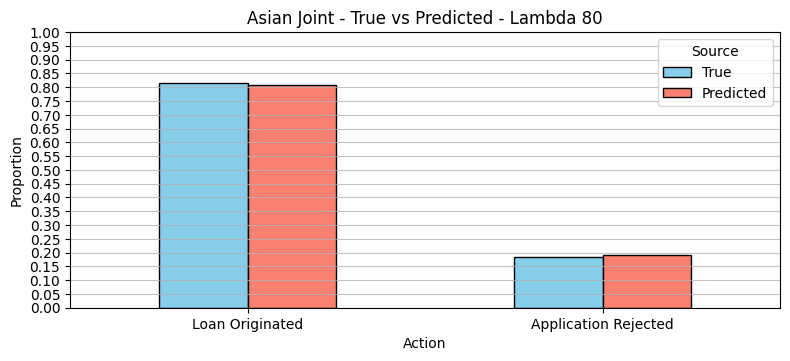

moo


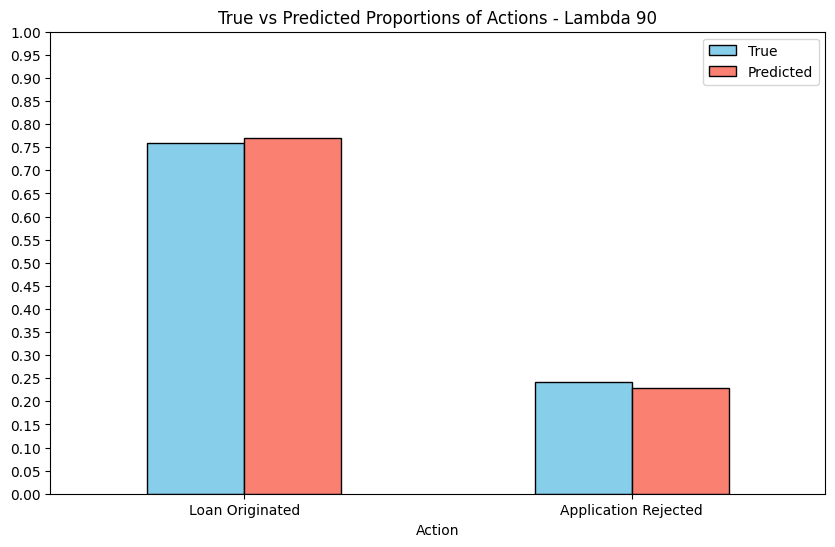

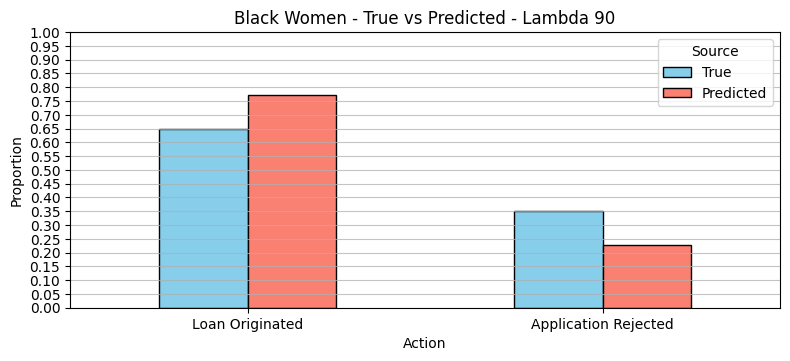

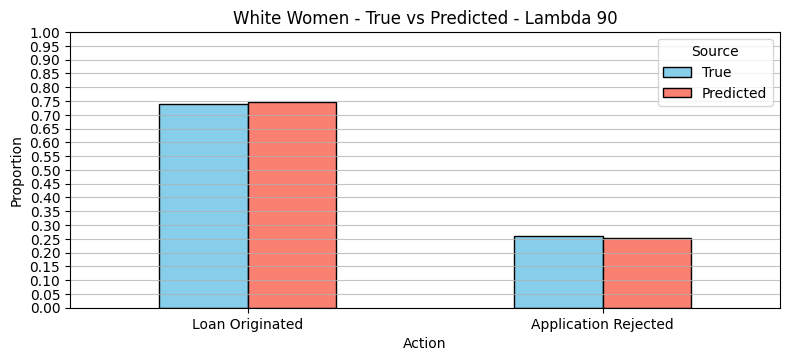

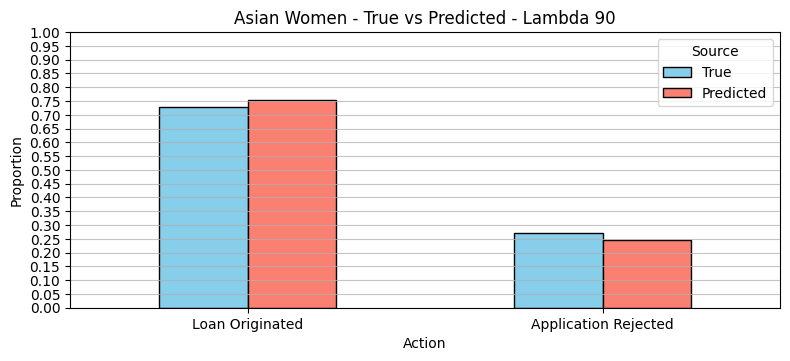

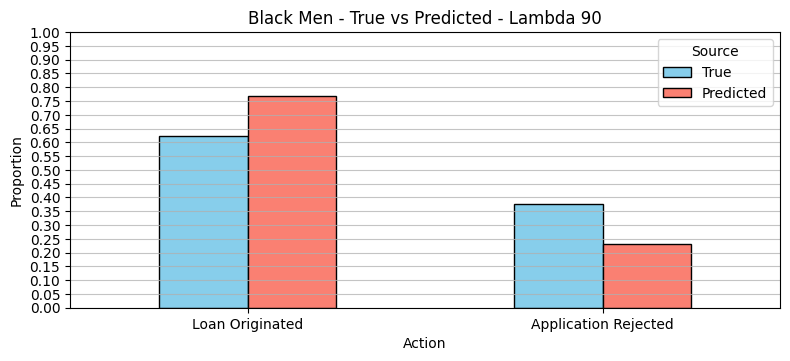

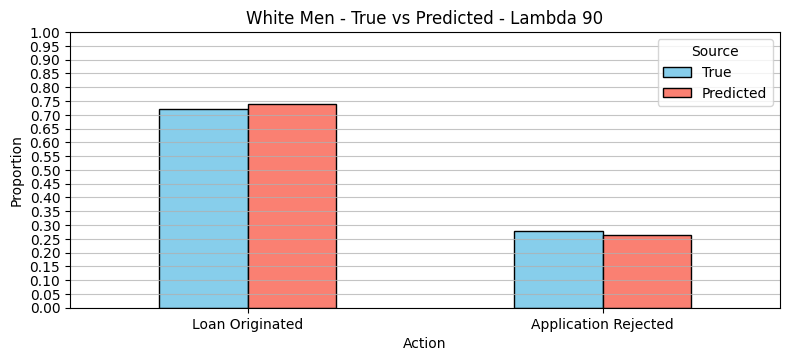

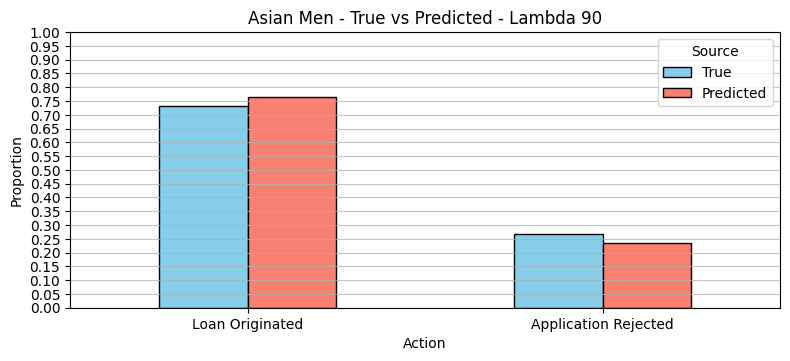

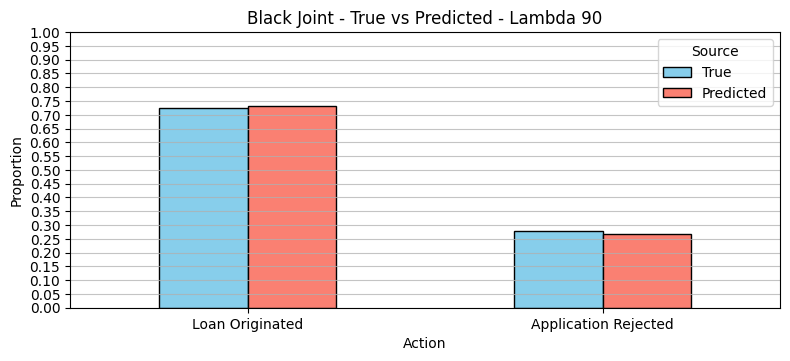

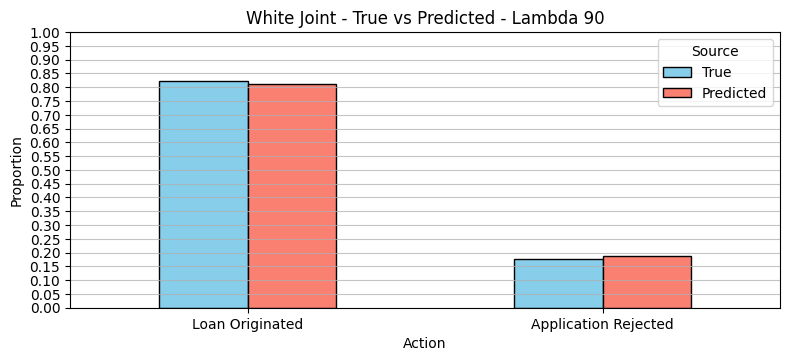

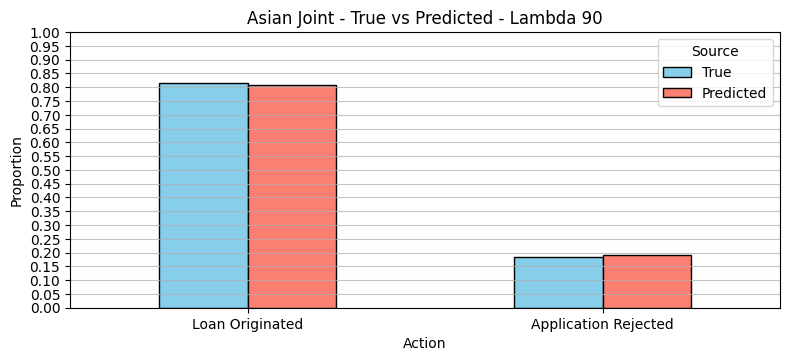

moo


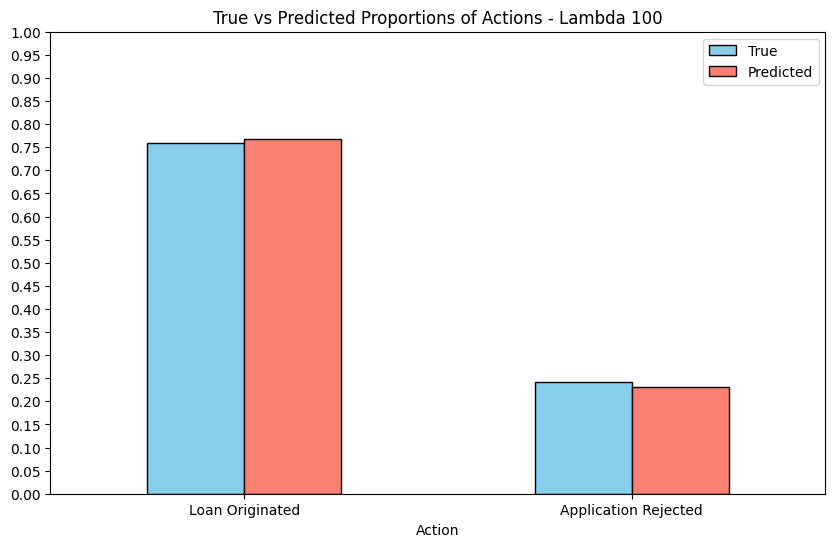

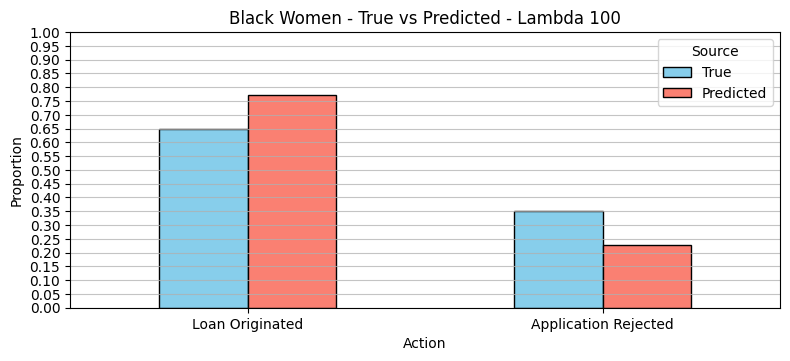

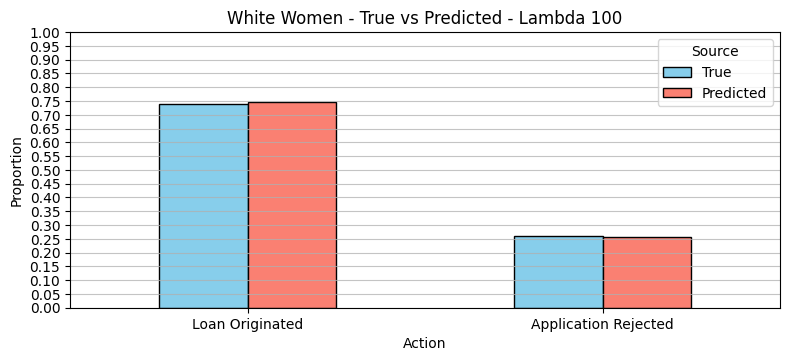

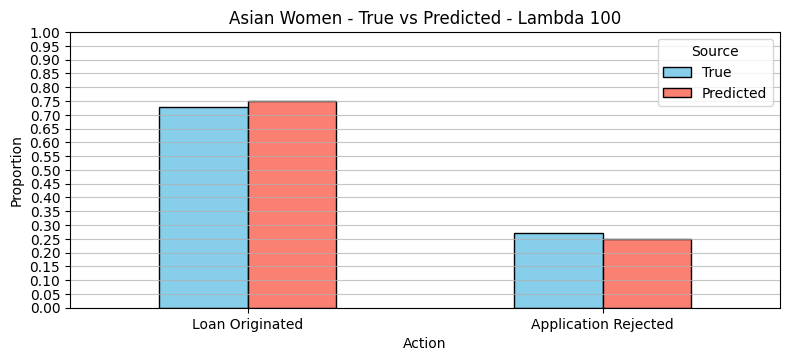

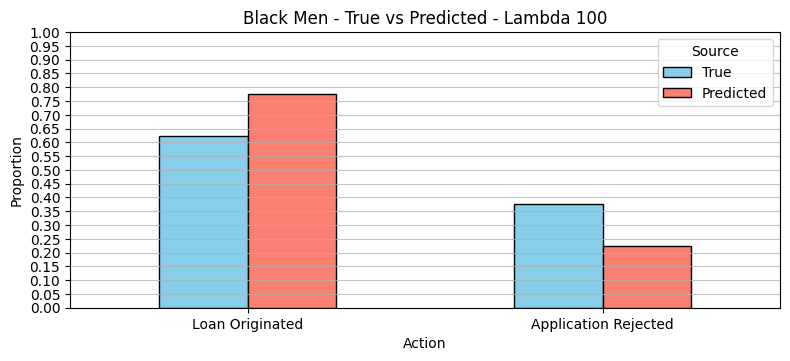

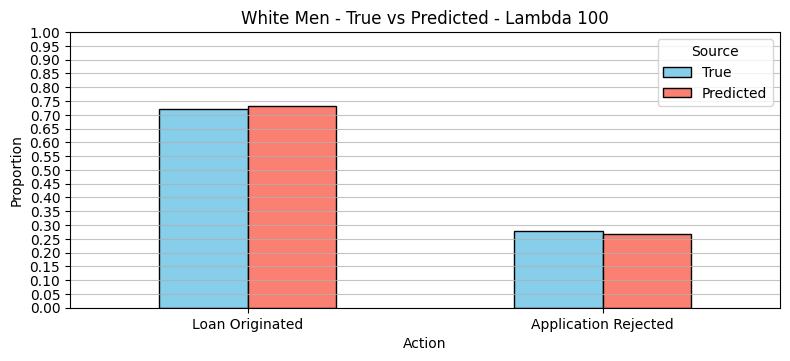

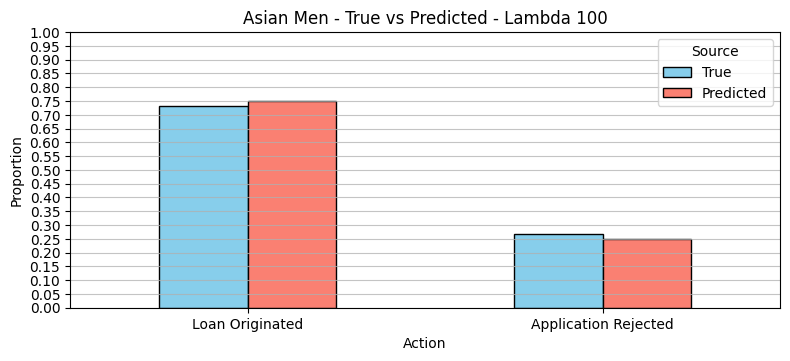

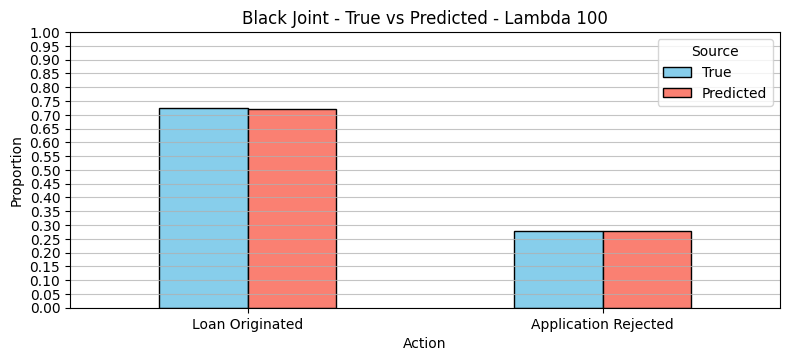

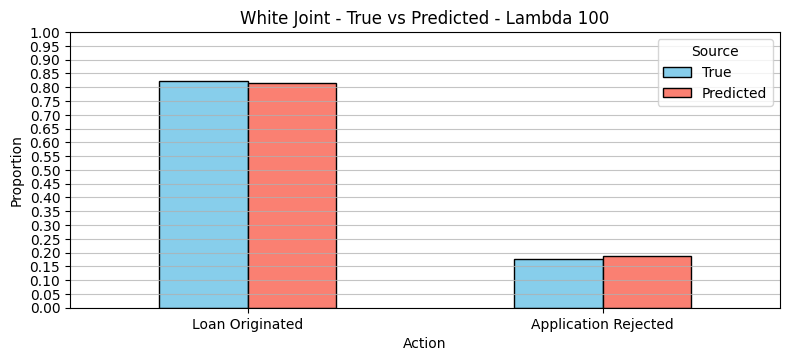

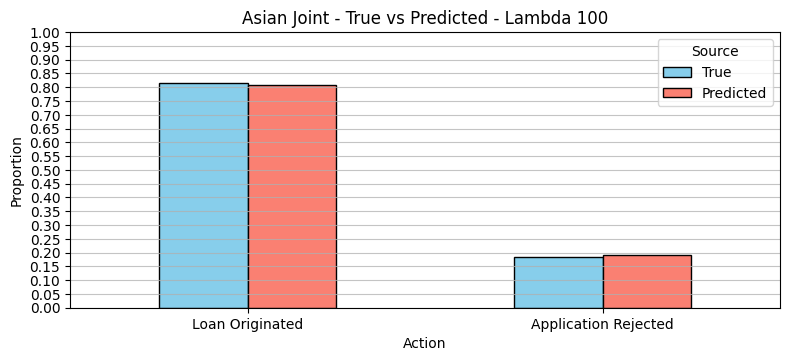

In [14]:
# So now I want to try and make an independent model. So note that this does not mean simply removing race and sex from the inputs.
# We want our model to have generally the same output distribution among all demographic groups.


train = True
lambda_fairnesses = [0, 1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
RACE_WHITE = feature_names.index('race_White')
RACE_BLACK = feature_names.index('race_Black')
RACE_ASIAN = feature_names.index('race_Asian')
SEX_MALE = feature_names.index('sex_Male')
SEX_FEMALE = feature_names.index('sex_Female')
SEX_JOINT = feature_names.index('sex_Joint')
for lambda_fairness in lambda_fairnesses:
    model, criterion, optimizer = instantiate_model()
    model_save_filepath = f'independent_deviations/independentCNN_{research}_{lambda_fairness}'
    if Path(model_save_filepath).exists():
        model.load_state_dict(torch.load(model_save_filepath, weights_only=True))
    elif(train):
        min_loss = float('inf')
        max_epochs = 1000
        max_epochs_without_improvement = 50
        current_epochs_without_improvement = 0
        
        for epoch in range(max_epochs):
            model.train()
            epoch_loss = 0.0
            for inputs, labels in train_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # === Fairness penalty (deviation from group mean) ===
                group_preds = []
                for race_idx in [RACE_WHITE, RACE_BLACK, RACE_ASIAN]:
                    for sex_idx in [SEX_MALE, SEX_FEMALE]:
                        mask = (inputs[:, 0, race_idx] > 0) & (inputs[:, 0, sex_idx] > 0)
                        if mask.any():
                            group_preds.append(outputs[mask].mean())
                group_preds_tensor = torch.stack(group_preds)
                group_mean = group_preds_tensor.mean()
                fairness_penalty = torch.mean((group_preds_tensor - group_mean) ** 2)
                loss += lambda_fairness * fairness_penalty

                # === Standard training steps ===
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            print(f"Lambda: {lambda_fairness} - Epoch {epoch + 1} - Loss: {epoch_loss:.4f}")

            if(epoch_loss < min_loss):
                torch.save(model.state_dict(), model_save_filepath)
                min_loss = epoch_loss
                current_epochs_without_improvement = 0
                print("Saved model")
            else:
                current_epochs_without_improvement += 1
                if current_epochs_without_improvement > max_epochs_without_improvement:
                    print("Stopped training")
                    break
    evaluate_independence(model_save_filepath,lambda_fairness, True, False)


Lambda: 0: 
Accuracy: 0.9741227475951768, 
AUC: 0.9964161023109483, 
Precision: 0.9878154289834175,
Recall: 0.9779792283807417, 
F1: 0.9828727200989975
4.664711365297751

Lambda: 1: 
Accuracy: 0.9769678905297385, 
AUC: 0.9971833162598575, 
Precision: 0.9891261296943075,
Recall: 0.9804418430350833, 
F1: 0.984764840837396
4.792519110706428

Lambda: 2: 
Accuracy: 0.9736621054057716, 
AUC: 0.9962413209897271, 
Precision: 0.9873860237142754,
Recall: 0.9778007780434705, 
F1: 0.9825700247462611
4.8805611276288925

Lambda: 5: 
Accuracy: 0.9722801788375559, 
AUC: 0.9958710174618092, 
Precision: 0.9853300733496333,
Recall: 0.9780506085156501, 
F1: 0.9816768461965575
5.210448768043277

Lambda: 10: 
Accuracy: 0.9720363094431649, 
AUC: 0.9958543813758994, 
Precision: 0.9844193143062286,
Recall: 0.978657339662372, 
F1: 0.9815298707806851
5.517333702637422

Lambda: 20: 
Accuracy: 0.9713047012599919, 
AUC: 0.9955785645503067, 
Precision: 0.9840563056592933,
Recall: 0.9780506085156501, 
F1: 0.981044265

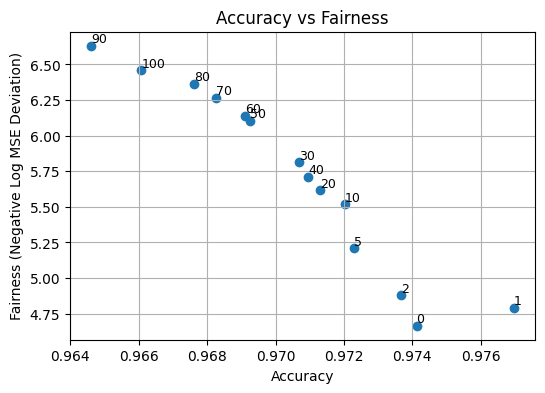

In [15]:
# Evaluate
fairnesses = []
accuracies = []
for lambda_fairness in lambda_fairnesses:
    path = f'independent_deviations/independentCNN_{research}_{lambda_fairness}'
    model.load_state_dict(torch.load(path, weights_only=True))
    print(f"Lambda: {lambda_fairness}: ")
    accuracies.append(evaluate(verbose=True))
    fairness = evaluate_independence(path, lambda_fairness, False, True)
    print(fairness)
    fairnesses.append(fairness)
    print()

plt.figure(figsize=(6, 4))
plt.scatter(accuracies, fairnesses)
for x, y, label in zip(accuracies, fairnesses, lambda_fairnesses):
    plt.text(x, y, label, fontsize=9, ha='left', va='bottom') 
plt.xlabel('Accuracy')
plt.ylabel('Fairness (Negative Log MSE Deviation)')
plt.title('Accuracy vs Fairness')
plt.grid(True)
plt.show()

So we can see from this graph that our best independent model is lambda = 50, with a relatively high accuracy of 0.967 and by far the highest fairness.

Continuing, let's experiment with PyTorch's OPACUS library without worrying about independence at all, just to see the tradeoffs between privacy and accuracy.

In [20]:
from opacus import PrivacyEngine
epsilon_values = [3, 5, 8, 10, 20, 0.01, 0.1, 1]
train = False
for epsilon_value in epsilon_values:
    model, criterion, optimizer = instantiate_model()
    if(train):
        privacy_engine = PrivacyEngine()
        train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
        model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            target_epsilon=epsilon_value,            # choose your privacy level (try 3–8 to start)
            target_delta=1e-7,             # usually 1 / num_examples
            epochs=1000,      # total number of epochs planned
            max_grad_norm=1.0              # gradient clipping
        )
    training_loop(train, f'raw_privacy/{epsilon_value}')
